In [6]:
import itertools
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math

from sklearn import metrics
from random import randint
from matplotlib import style

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

In [8]:
df = pd.read_csv('curriculum_logs.csv')

# concatenate and change date type columns to the respective type 
df['date_time'] = df.date + ' ' + df.time
df.date_time = pd.to_datetime(df.date_time, format = '%Y-%m-%d %H:%M:%S')
df.date = pd.to_datetime(df.date)
df.time = pd.to_datetime(df.time).dt.time
df.start_date = pd.to_datetime(df.start_date)
df.end_date = pd.to_datetime(df.end_date)
df.created_at = pd.to_datetime(df.created_at)
df.deleted_at = pd.to_datetime(df.deleted_at)

# missing entirety of columns
df.drop(['Unnamed: 0', 'id', 'slack','deleted_at'], inplace = True, axis = 1)

# let's clean up the dataset
df.dropna(inplace = True)

# set the index
df = df.set_index(df.date)

# let's rename some columns
df.rename(columns = {'path':'endpoint', 'ip':'source_ip', 'name':'cohort_name'}, inplace = True)

# let's remove the staff members since this exercise pertains to students
df = df[df['cohort_name'] != 'Staff']

# add program name and course to dataframe
df['program_name'] = df.program_id.map({1.0: 'PHP Full Stack Web Development',
                                        2.0: 'Java Full Stack Web Development',
                                        3.0: 'Data Science',
                                        4.0: 'Front End Web Development'})

df['course'] = df.program_id.map({1.0: 'Web Development',
                                   2.0: 'Web Development',
                                   3.0: 'Data Science',
                                   4.0: 'Web Development'})

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 763298 entries, 2018-01-26 to 2021-04-21
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date          763298 non-null  datetime64[ns]
 1   time          763298 non-null  object        
 2   endpoint      763298 non-null  object        
 3   user_id       763298 non-null  int64         
 4   cohort_id     763298 non-null  float64       
 5   source_ip     763298 non-null  object        
 6   cohort_name   763298 non-null  object        
 7   start_date    763298 non-null  datetime64[ns]
 8   end_date      763298 non-null  datetime64[ns]
 9   created_at    763298 non-null  datetime64[ns]
 10  updated_at    763298 non-null  object        
 11  program_id    763298 non-null  float64       
 12  date_time     763298 non-null  datetime64[ns]
 13  program_name  763298 non-null  object        
 14  course        763298 non-null  object        
dtypes

In [9]:
df.head()

date      time                             endpoint  user_id  \
date                                                                            
2018-01-26 2018-01-26  09:55:03                                    /        1   
2018-01-26 2018-01-26  09:56:02                              java-ii        1   
2018-01-26 2018-01-26  09:56:05  java-ii/object-oriented-programming        1   
2018-01-26 2018-01-26  09:56:06   slides/object_oriented_programming        1   
2018-01-26 2018-01-26  09:56:24            javascript-i/conditionals        2   

            cohort_id     source_ip cohort_name start_date   end_date  \
date                                                                    
2018-01-26        8.0  97.105.19.61     Hampton 2015-09-22 2016-02-06   
2018-01-26        8.0  97.105.19.61     Hampton 2015-09-22 2016-02-06   
2018-01-26        8.0  97.105.19.61     Hampton 2015-09-22 2016-02-06   
2018-01-26        8.0  97.105.19.61     Hampton 2015-09-22 2016-02-06   
2018-01-26       22.0  97.105.19.61       Teddy 2018-01-08 2018-05-17   

                    created_at           updated_at  program_id  \
date                                                              
2018-01-26 2016-06-14 19:52:26  2016-06-14 19:52:26         1.0   
2018-01-26 2016-06-14 19:52:26  2016-06-14 19:52:26         1.0   
2018-01-26 2016-06-14 19:52:26  2016-06-14 19:52:26         1.0   
2018-01-26 2016-06-14 19:52:26  2016-06-14 19:52:26         1.0   
2018-01-26 2018-01-08 13:59:10  2018-01-08 13:59:10         2.0   

                     date_time                     program_name  \
date                                                              
2018-01-26 2018-01-26 09:55:03   PHP Full Stack Web Development   
2018-01-26 2018-01-26 09:56:02   PHP Full Stack Web Development   
2018-01-26 2018-01-26 09:56:05   PHP Full Stack Web Development   
2018-01-26 2018-01-26 09:56:06   PHP Full Stack Web Development   
2018-01-26 2018-01-26 09:56:24  Java Full Stack Web Development   

                     course  
date                         
2018-01-26  Web Development  
2018-01-26  Web Development  
2018-01-26  Web Development  
2018-01-26  Web Development  
2018-01-26  Web Development

1. Which lesson appears to attract the most traffic consistently across cohorts (per program)?

In [10]:
cohort_program = pd.DataFrame(columns = ['cohort','program_name'])
for cohort in df.cohort_name.unique():
    for program in df[df['cohort_name'] == cohort].program_name.unique():
        cohort_program = cohort_program.append({'cohort':cohort, 'program_name':program}, ignore_index = True)
cohort_program.T

0                                1   \
cohort                               Hampton                            Teddy   
program_name  PHP Full Stack Web Development  Java Full Stack Web Development   

                                           2                               3   \
cohort                                Sequoia                          Arches   
program_name  Java Full Stack Web Development  PHP Full Stack Web Development   

                                           4   \
cohort                                Niagara   
program_name  Java Full Stack Web Development   

                                           5                               6   \
cohort                              Pinnacles                          Quincy   
program_name  Java Full Stack Web Development  PHP Full Stack Web Development   

                                          7                               8   \
cohort                                 Kings                          Lassen   
program_name  PHP Full Stack Web Development  PHP Full Stack Web Development   

                                           9   ...            36  \
cohort                                Mammoth  ...        Darden   
program_name  Java Full Stack Web Development  ...  Data Science   

                                           37  \
cohort                                   Bash   
program_name  Java Full Stack Web Development   

                                           38  \
cohort                                Jupiter   
program_name  Java Full Stack Web Development   

                                           39  \
cohort                                Kalypso   
program_name  Java Full Stack Web Development   

                                           40            41  \
cohort                                   Luna        Easley   
program_name  Java Full Stack Web Development  Data Science   

                                           42  \
cohort                                  Marco   
program_name  Java Full Stack Web Development   

                                           43            44  \
cohort                                Neptune      Florence   
program_name  Java Full Stack Web Development  Data Science   

                                           45  
cohort                                 Oberon  
program_name  Java Full Stack Web Development  

[2 rows x 46 columns]

In [11]:
df_dw = df.copy()

In [12]:
# after going through the contents of the endpoint feature, the following words were 
# identified and need to be removed as these are only elements of the web page or the 
# introductory page
dropped_words = ['/', '.jpg', '.json', '.gif', '.png', '.jpeg', '.svg']

In [13]:
# let's remove the words in the dropped_words list
for word in dropped_words:
    df_dw = df_dw[~df_dw['endpoint'].str.endswith(word)]

In [8]:
df_dw[df_dw['program_name'] == 'Data Science'].endpoint.nunique()

631

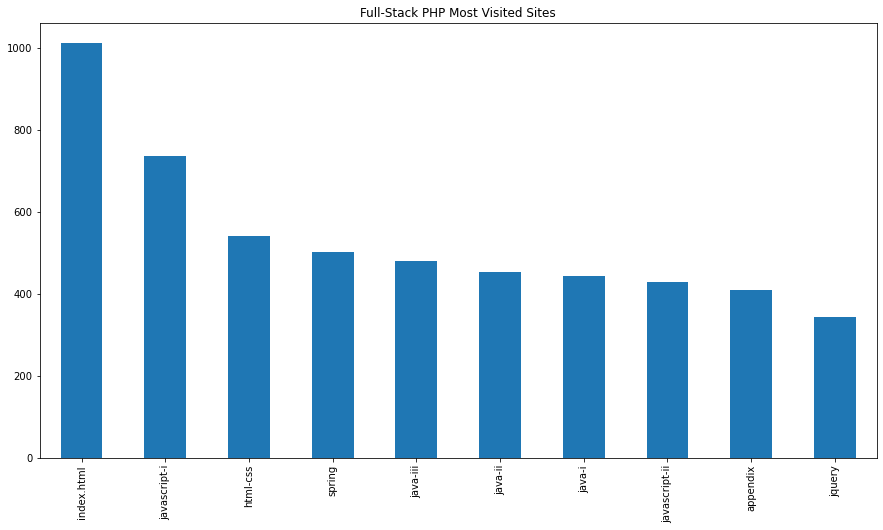

In [9]:
df_dw[df_dw['program_name'] == 'PHP Full Stack Web Development'].endpoint.value_counts().head(10).plot.bar(title = 'Full-Stack PHP Most Visited Sites', figsize = (15,8));

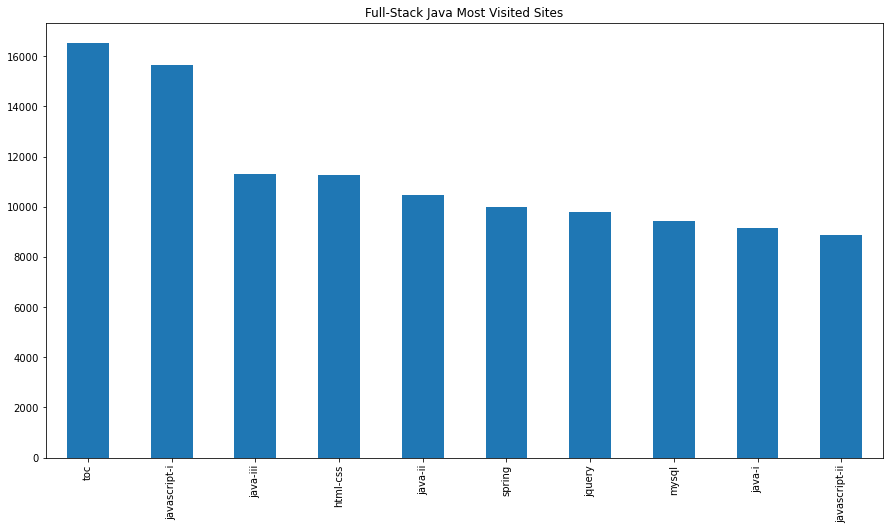

In [10]:
df_dw[df_dw['program_name'] == 'Java Full Stack Web Development'].endpoint.value_counts().head(10).plot.bar(title = 'Full-Stack Java Most Visited Sites', figsize = (15,8));

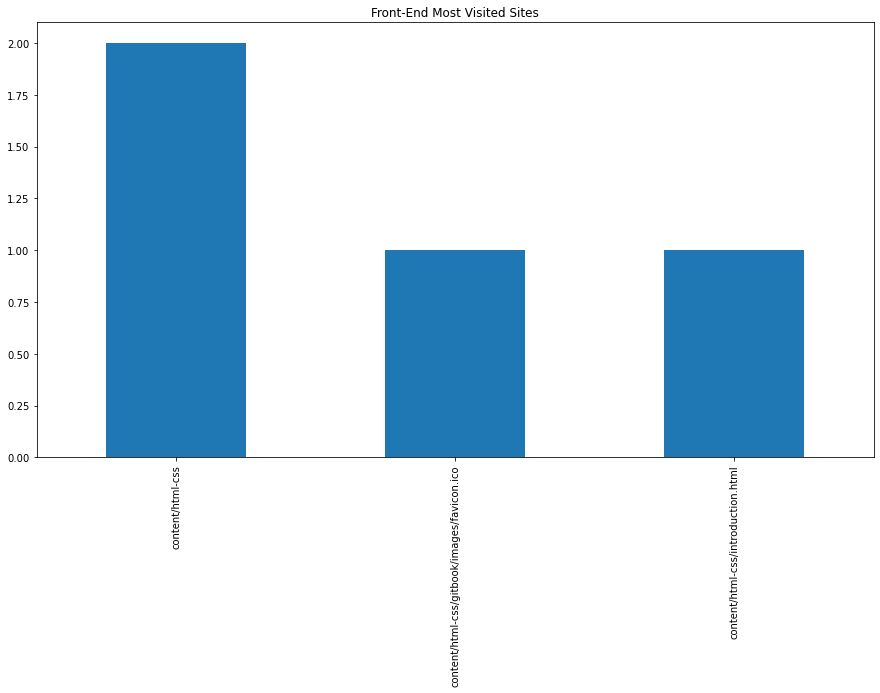

In [11]:
df_dw[df_dw['program_name'] == 'Front End Web Development'].endpoint.value_counts().head(10).plot.bar(title = 'Front-End Most Visited Sites', figsize = (15,8));

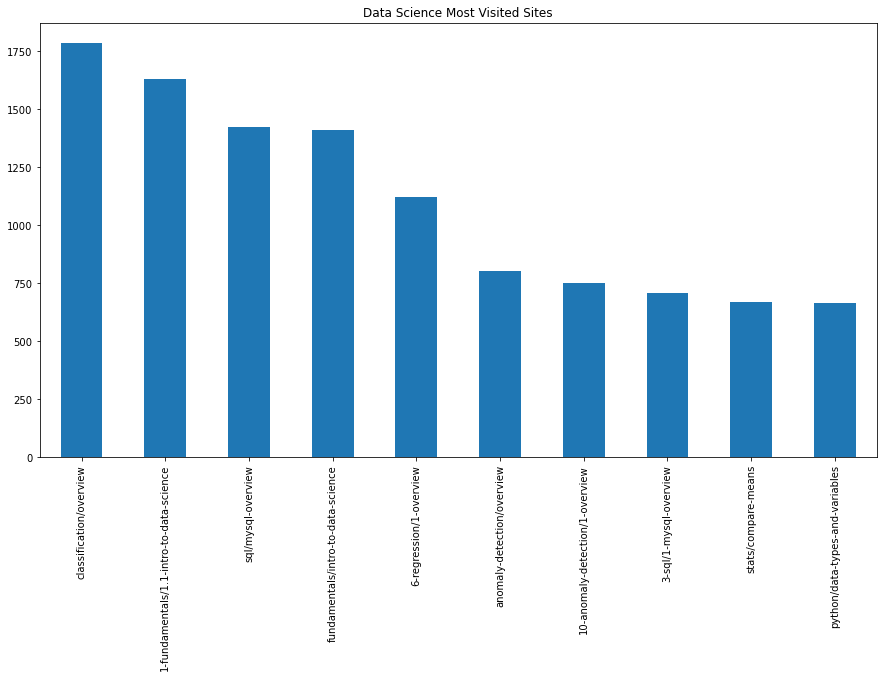

In [12]:
df_dw[df_dw['program_name'] == 'Data Science'].endpoint.value_counts().head(10).plot.bar(title = 'Data Science Most Visited Sites', figsize = (15,8));

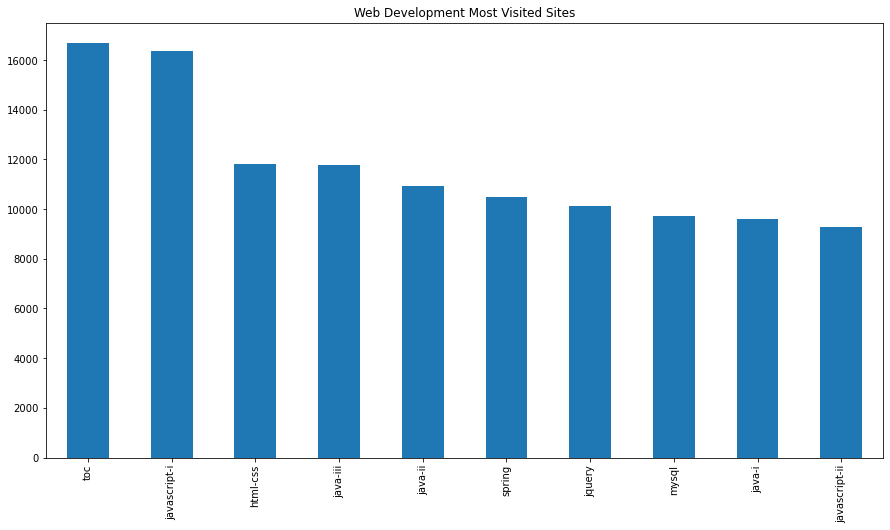

In [13]:
df_dw[df_dw['course'] == 'Web Development'].endpoint.value_counts().head(10).plot.bar(title = 'Web Development Most Visited Sites', figsize = (15,8));

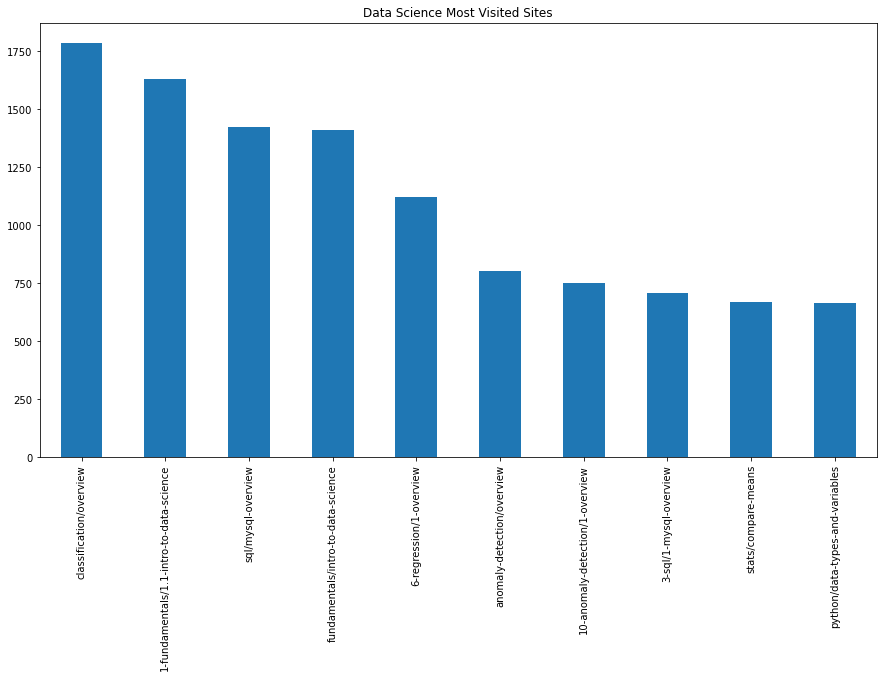

In [14]:
df_dw[df_dw['course'] == 'Data Science'].endpoint.value_counts().head(10).plot.bar(title = 'Data Science Most Visited Sites', figsize = (15,8));

2. Is there a cohort that referred to a lesson significantly more than other cohorts seemed to gloss over?

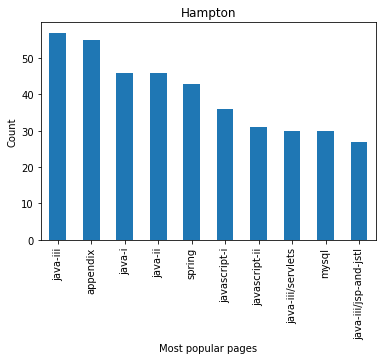

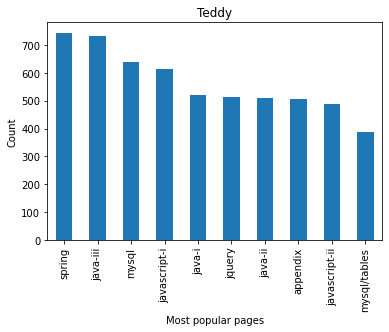

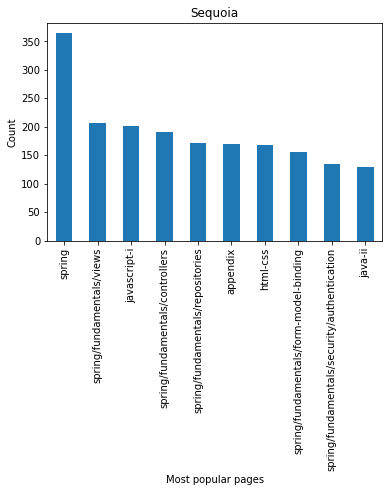

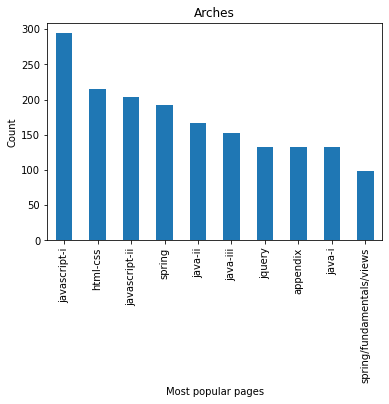

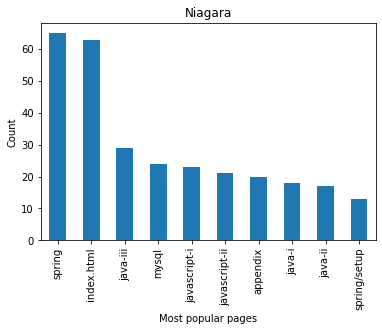

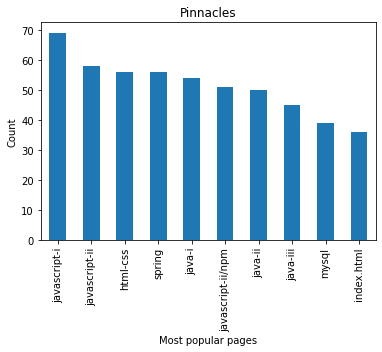

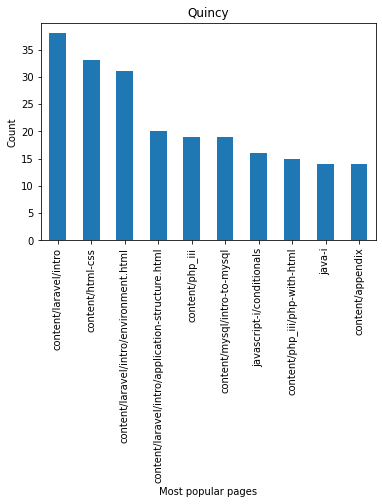

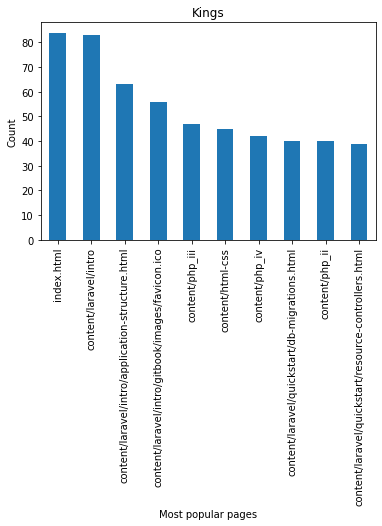

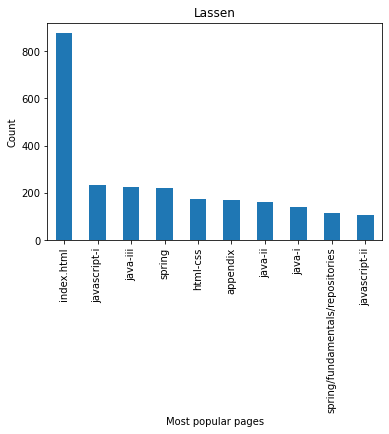

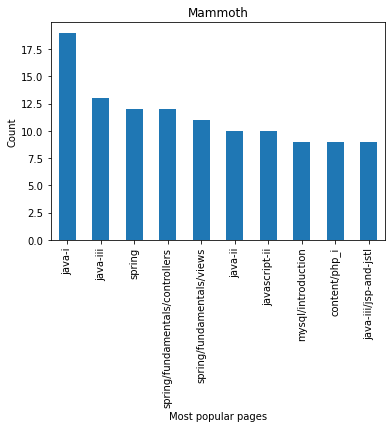

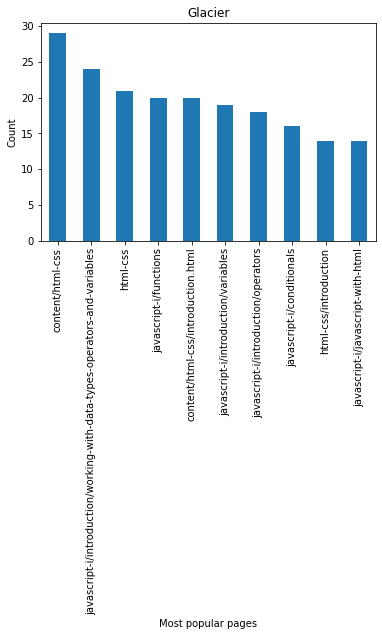

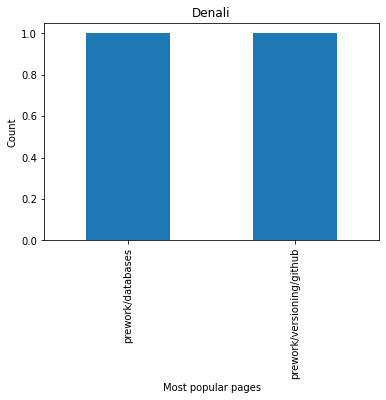

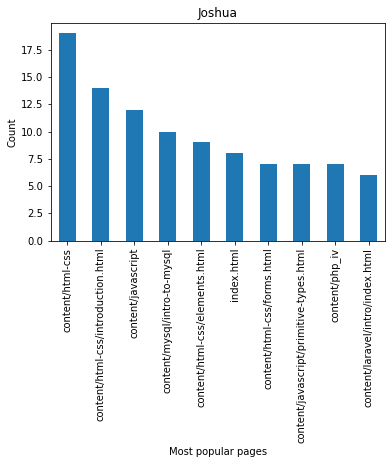

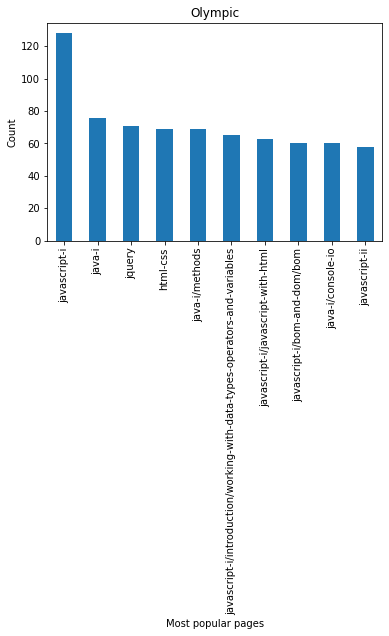

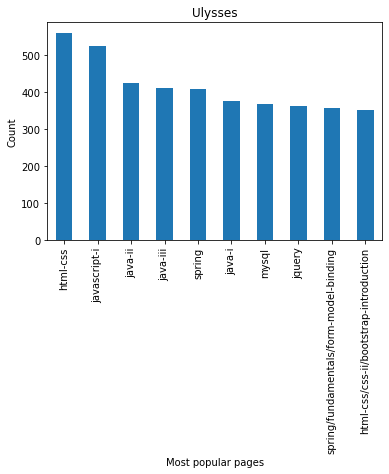

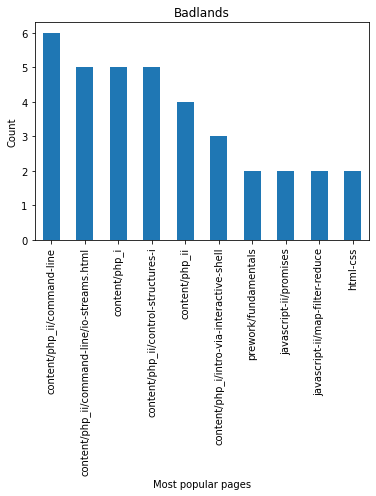

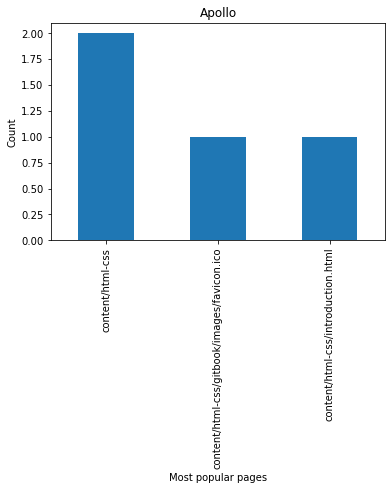

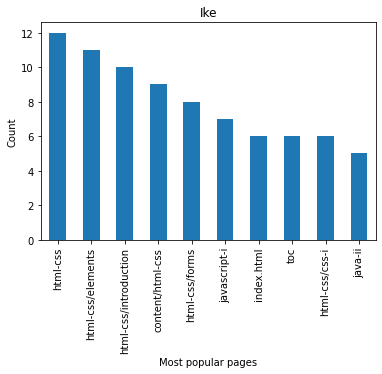

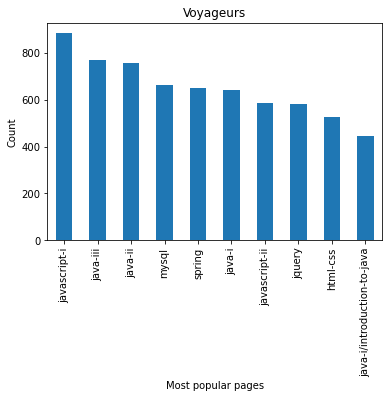

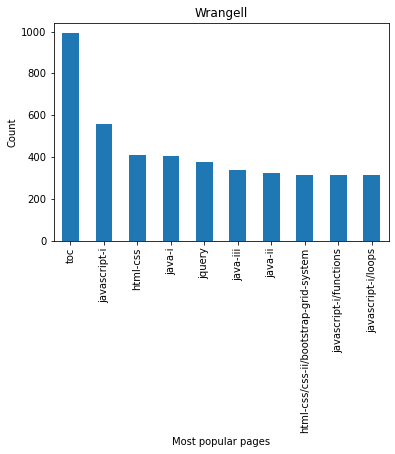

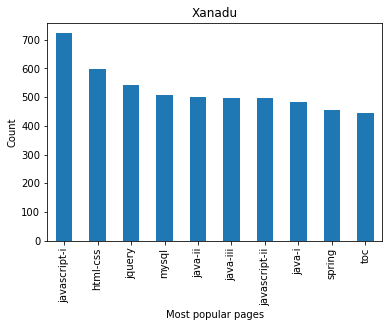

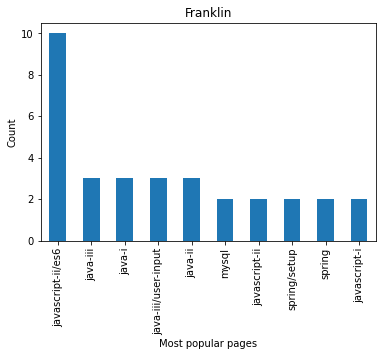

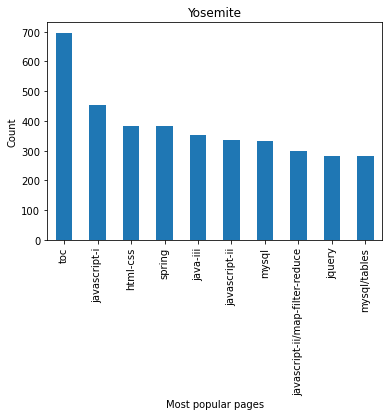

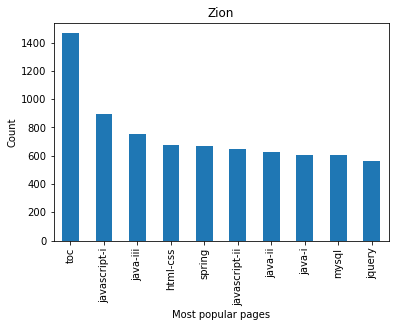

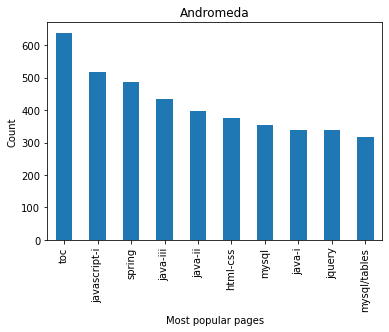

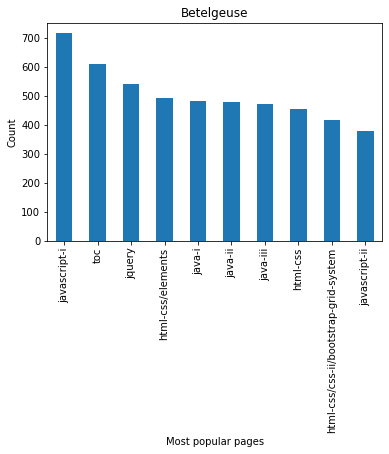

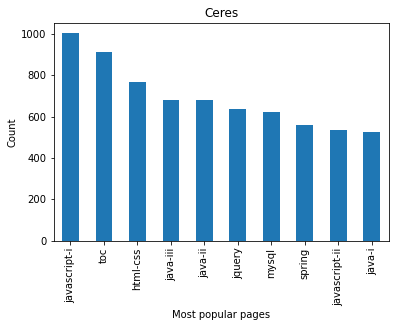

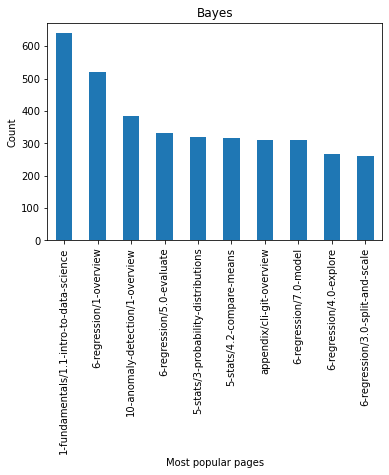

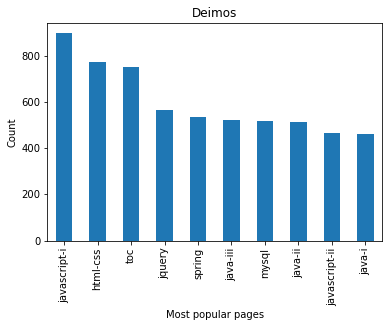

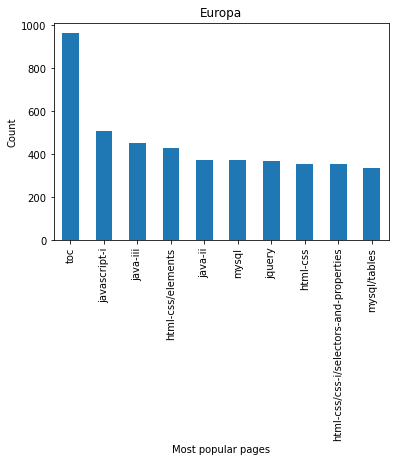

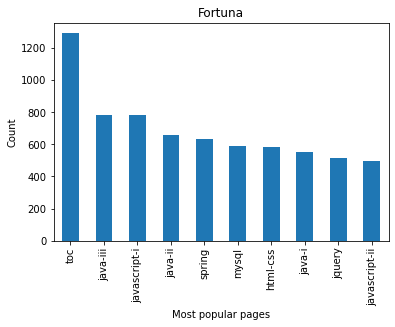

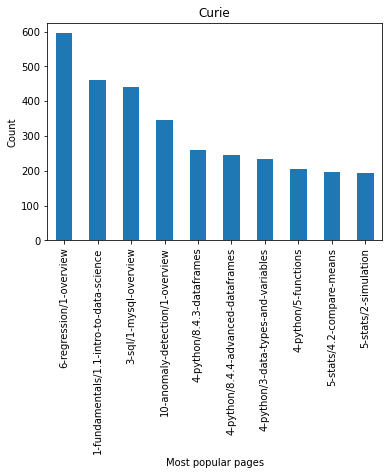

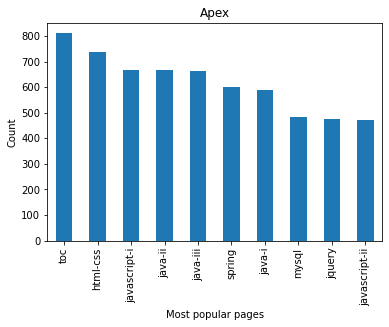

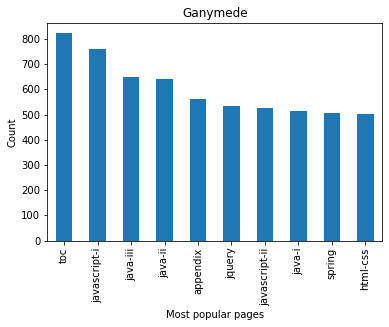

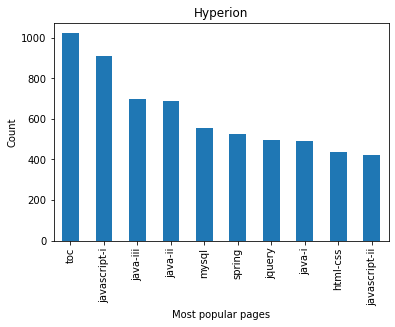

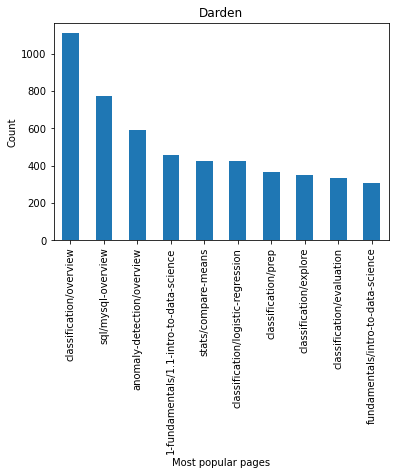

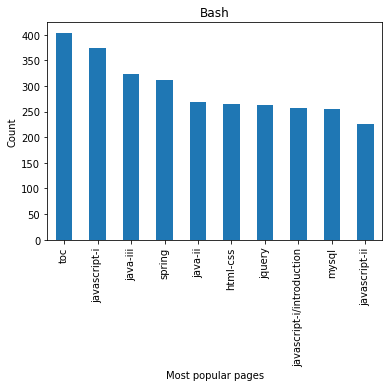

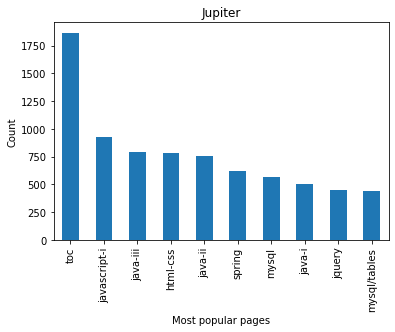

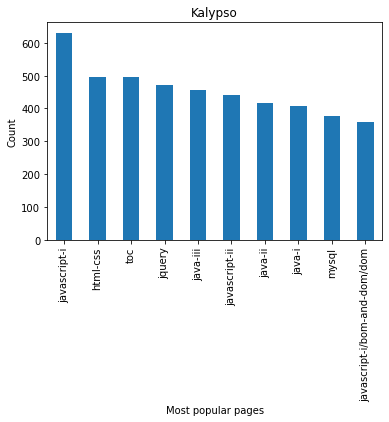

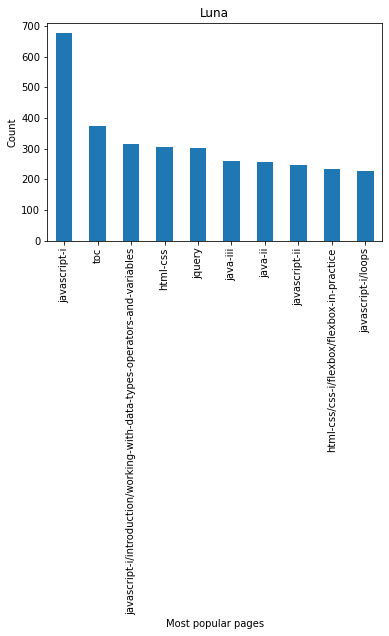

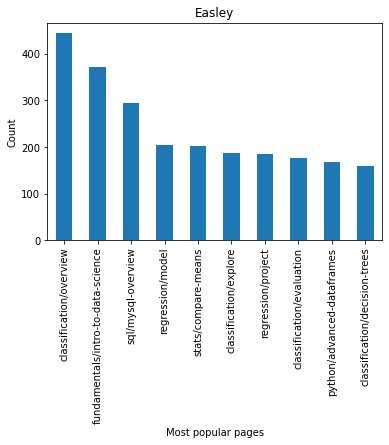

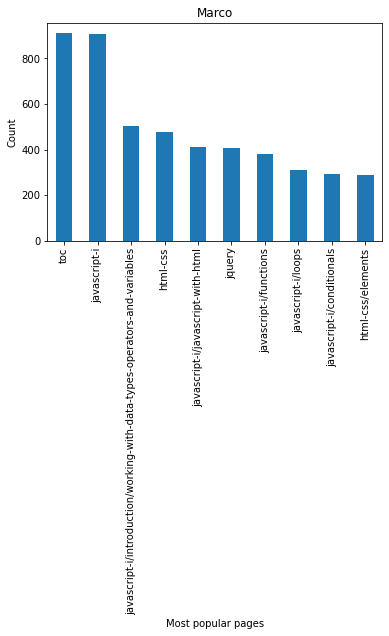

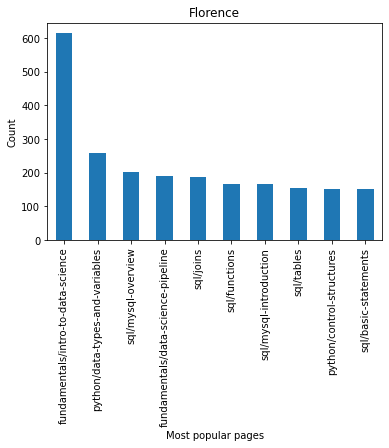

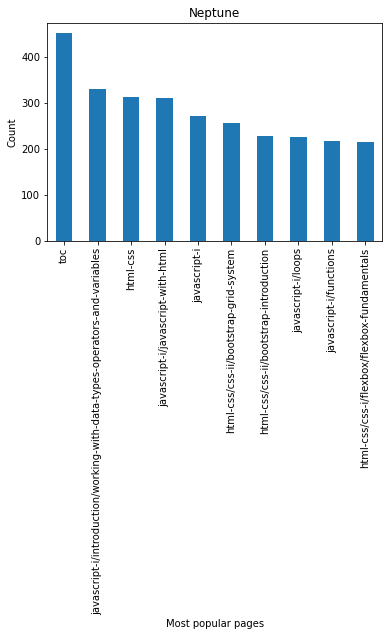

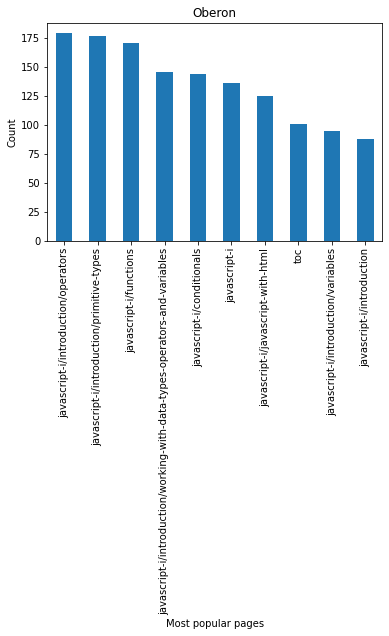

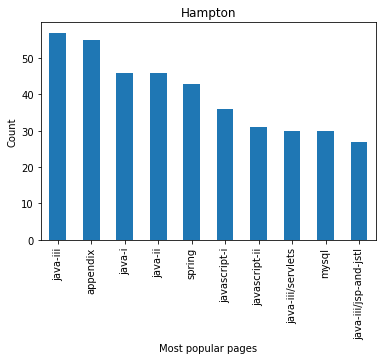

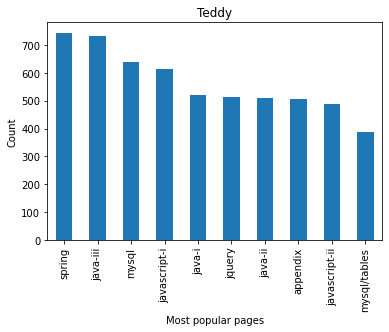

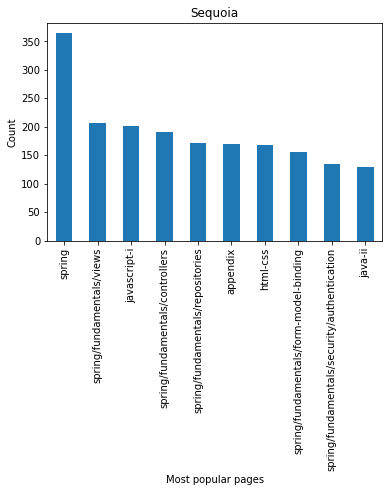

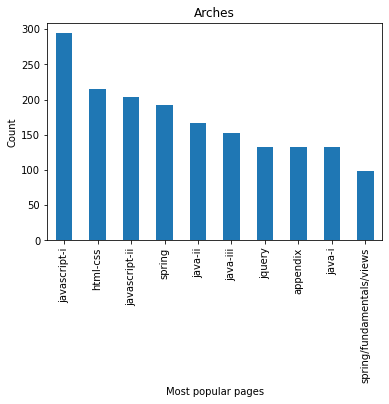

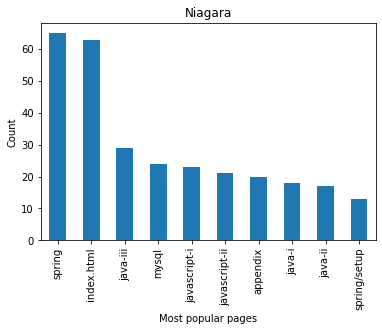

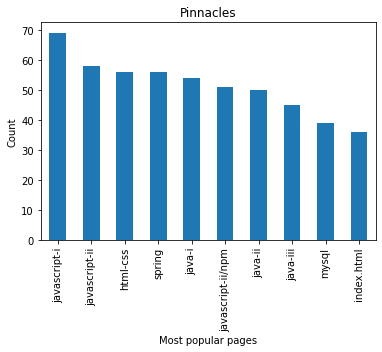

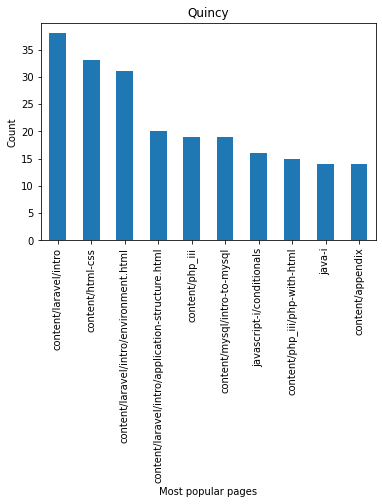

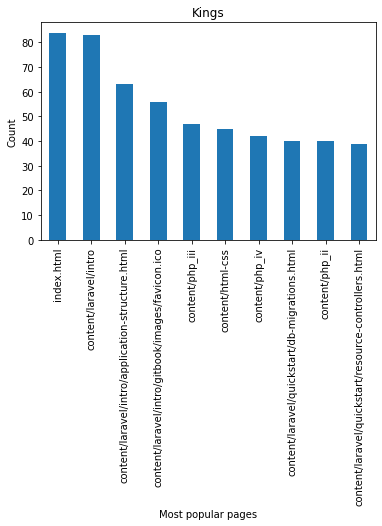

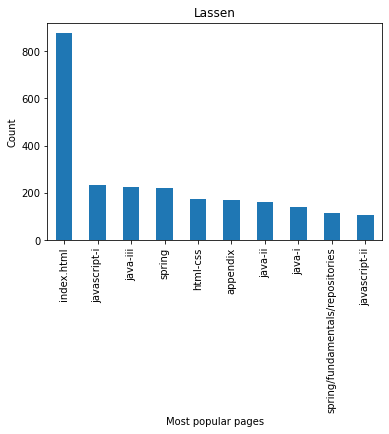

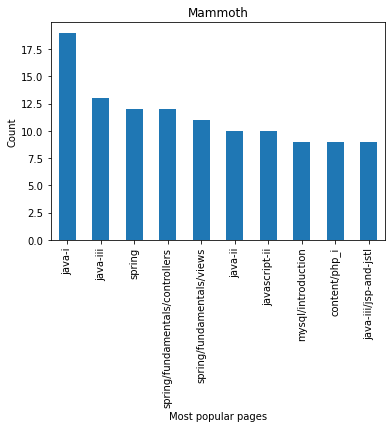

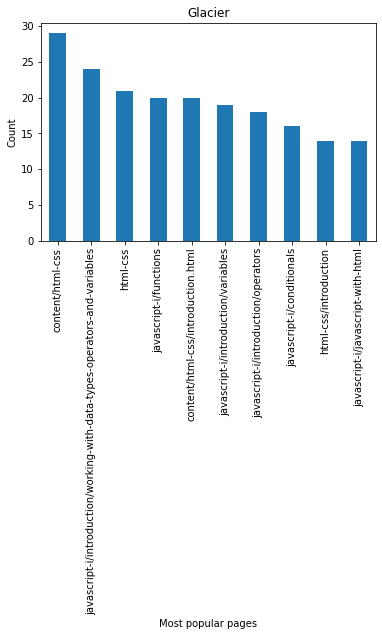

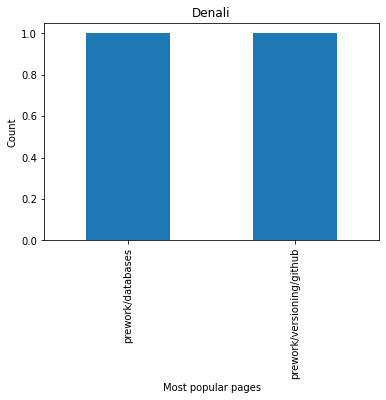

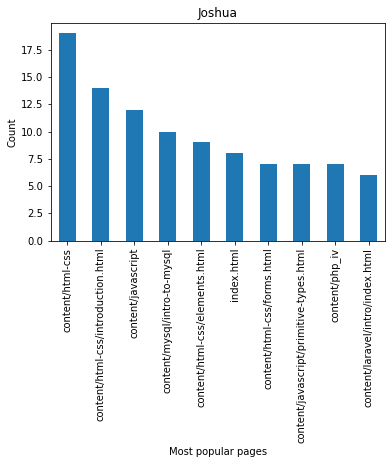

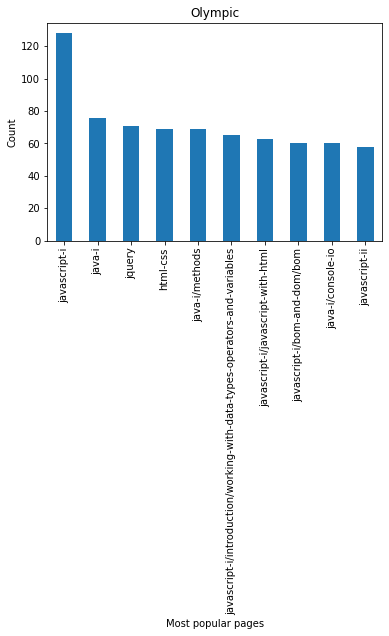

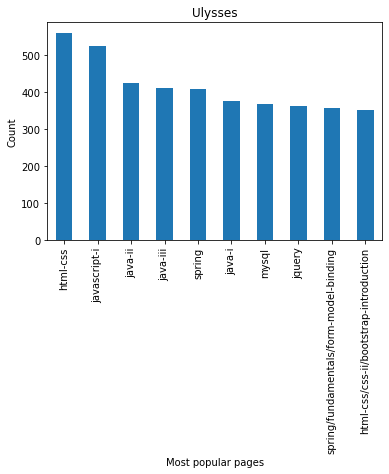

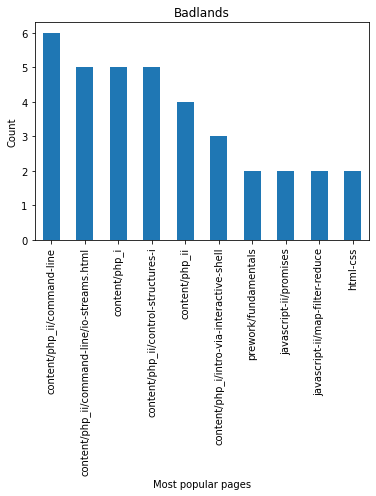

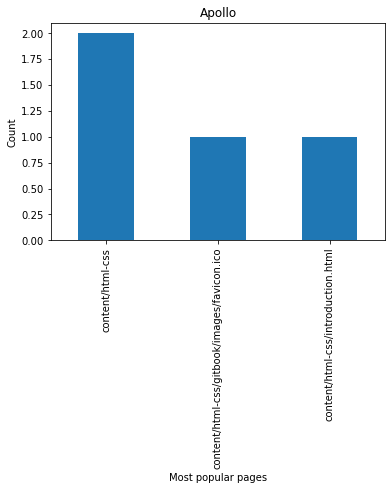

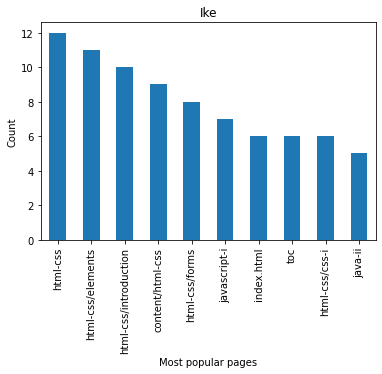

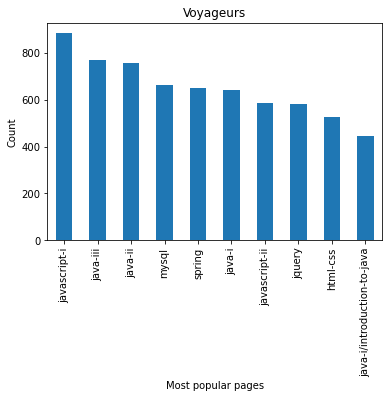

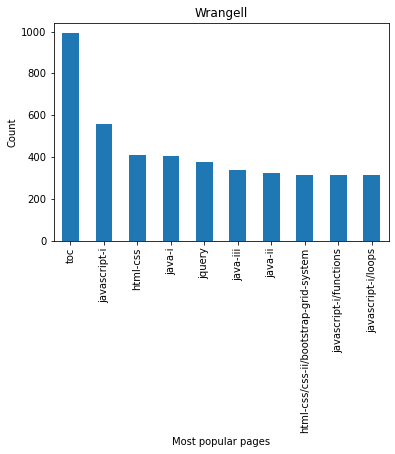

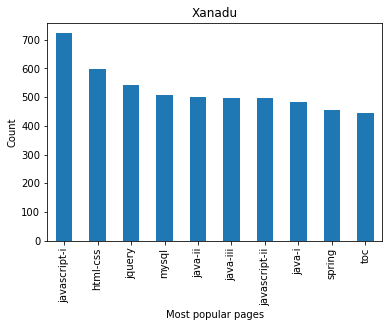

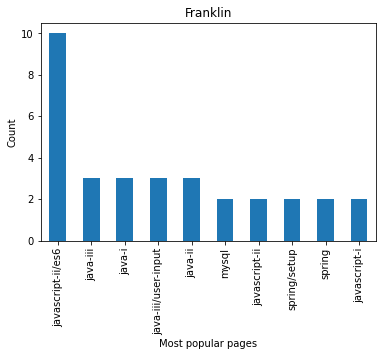

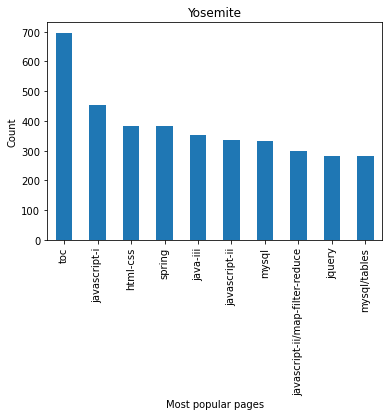

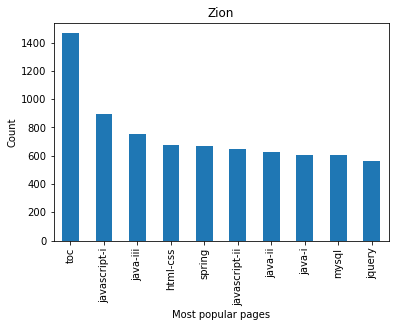

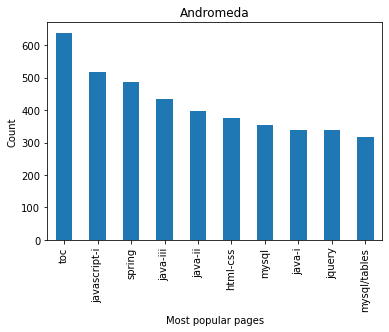

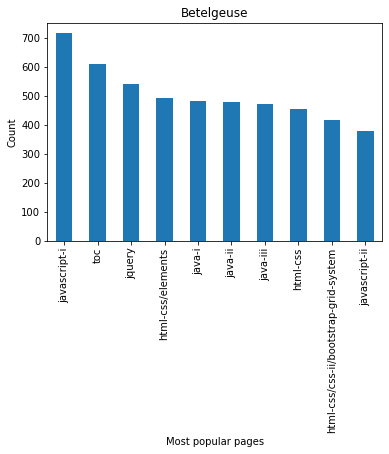

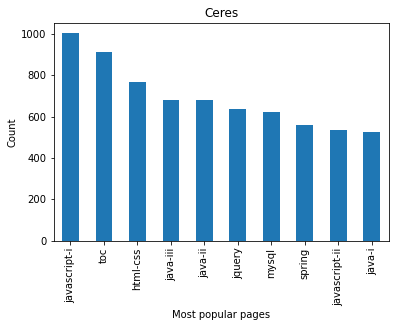

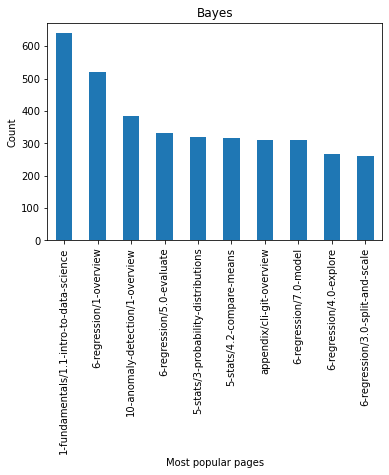

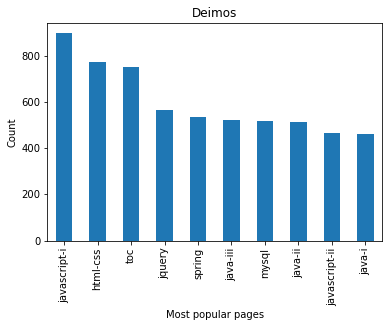

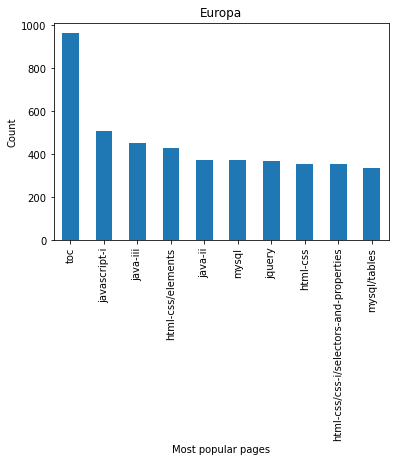

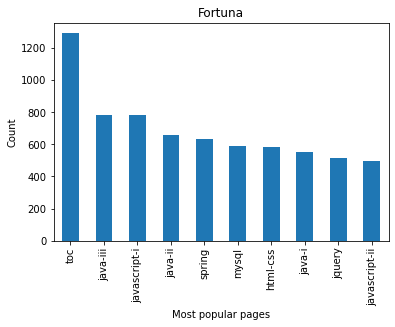

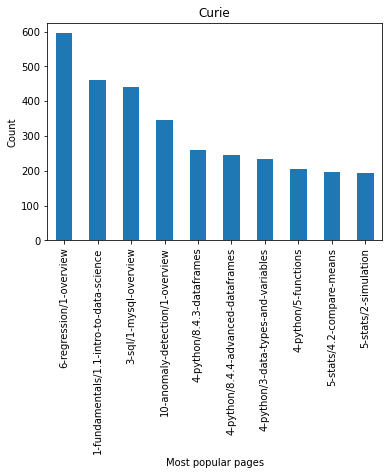

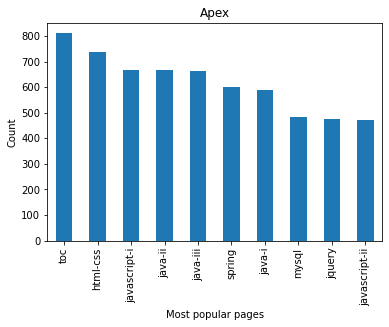

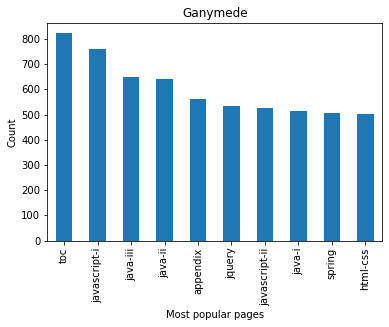

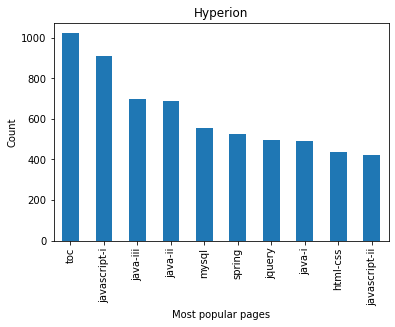

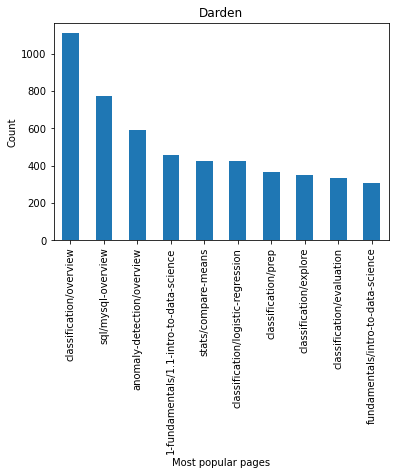

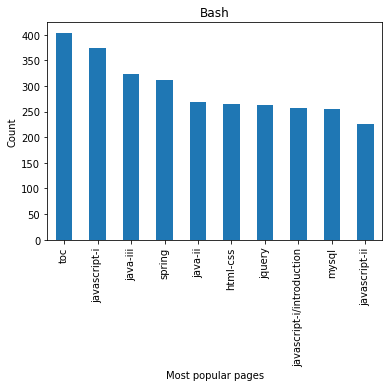

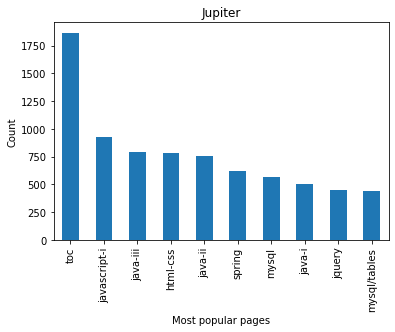

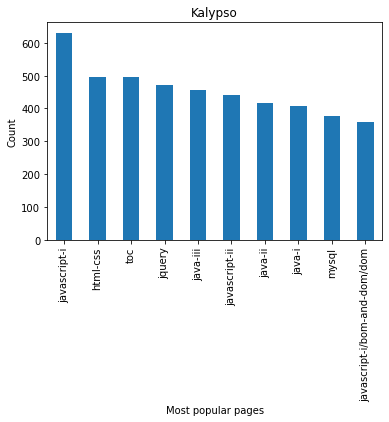

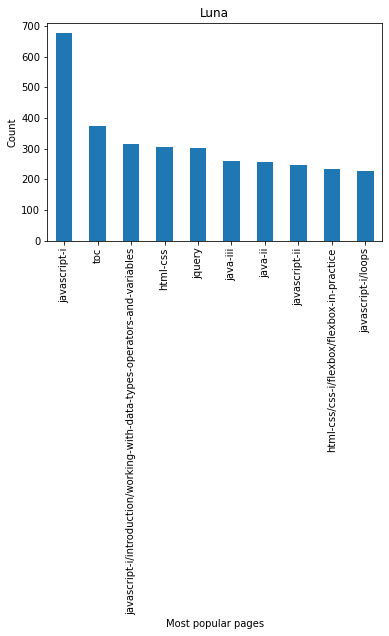

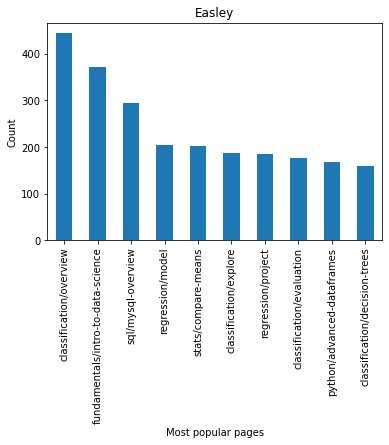

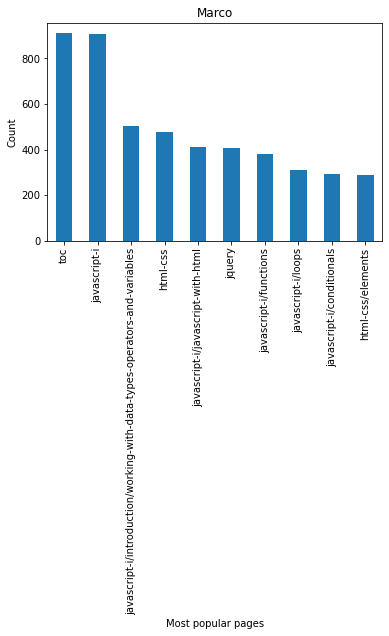

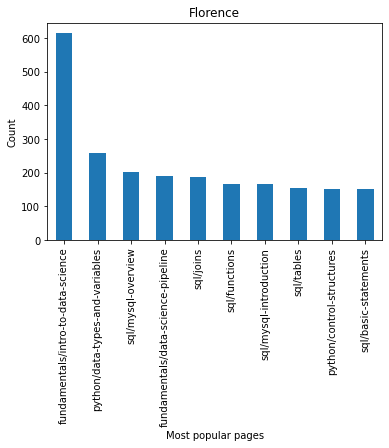

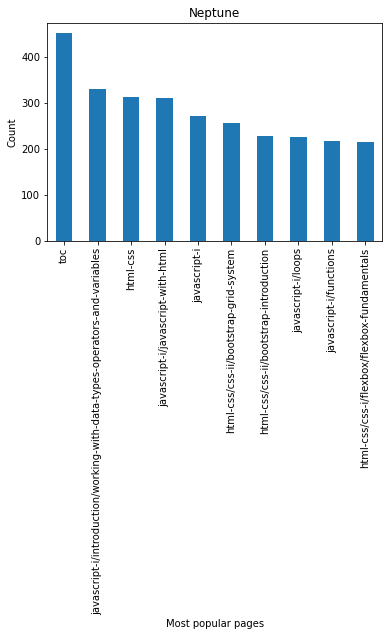

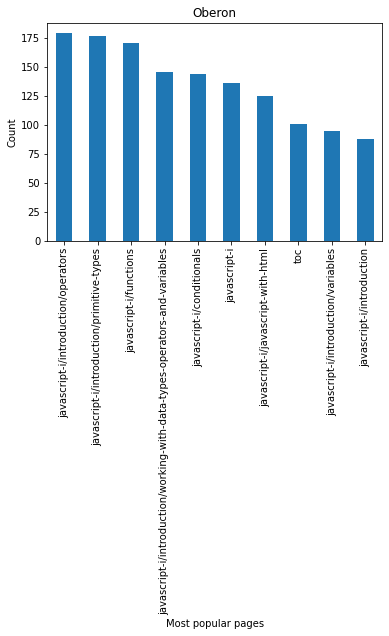

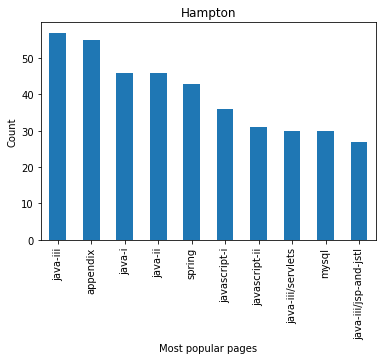

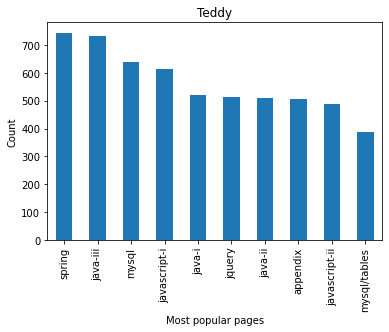

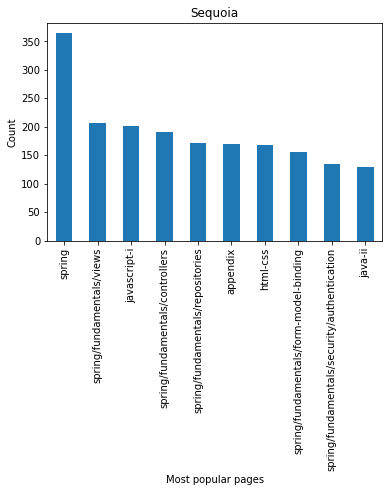

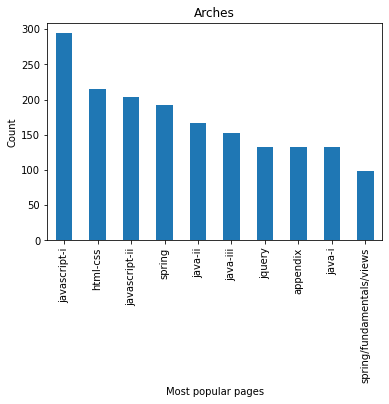

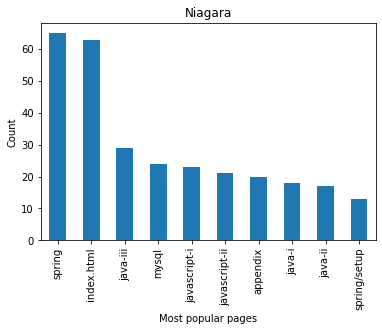

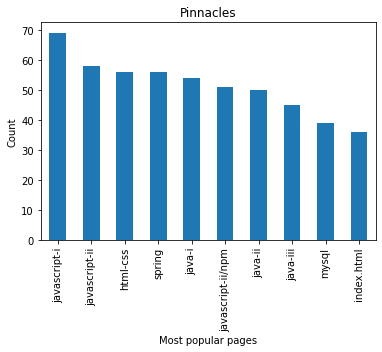

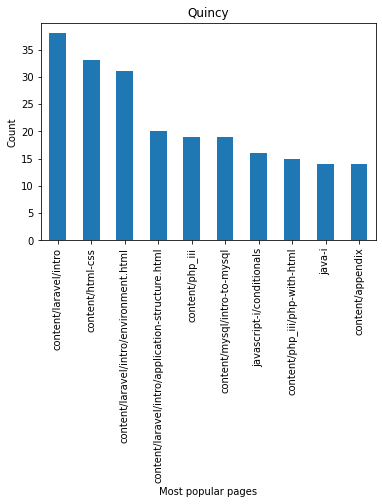

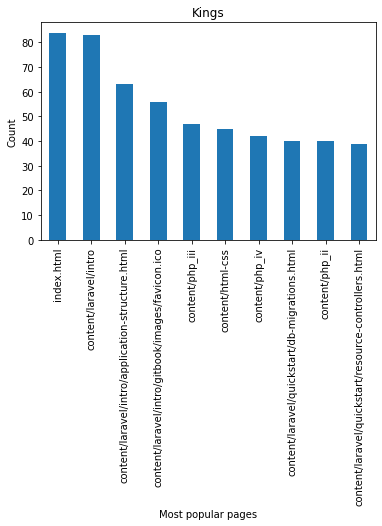

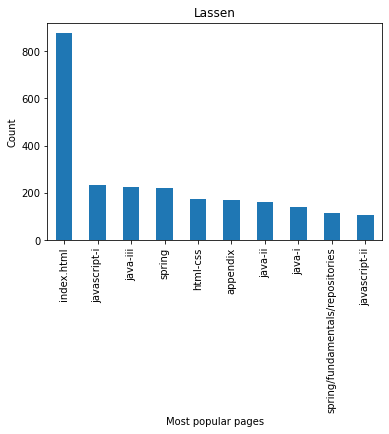

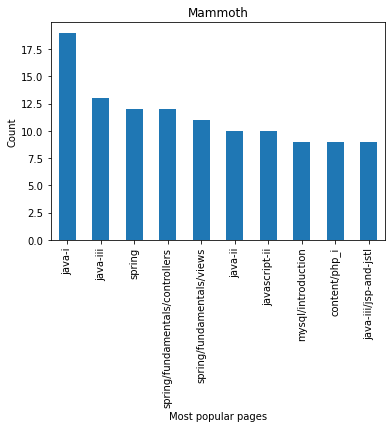

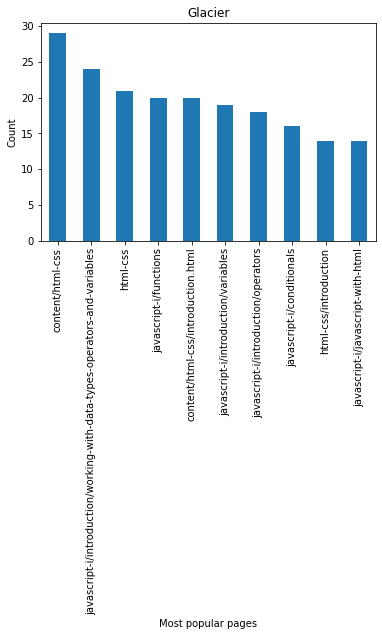

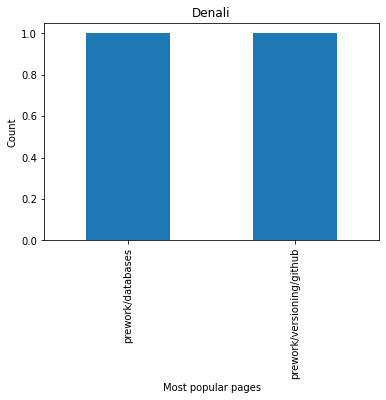

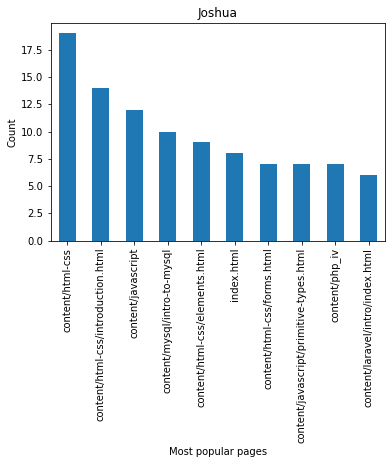

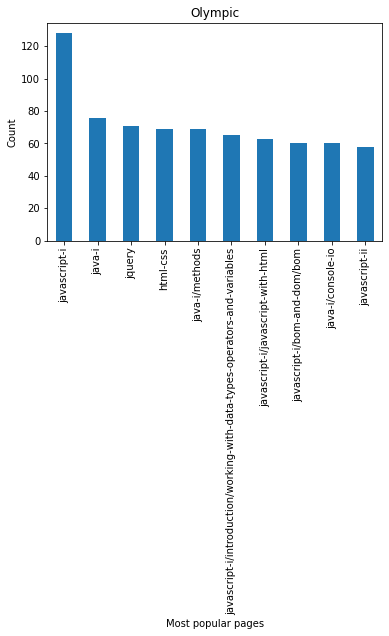

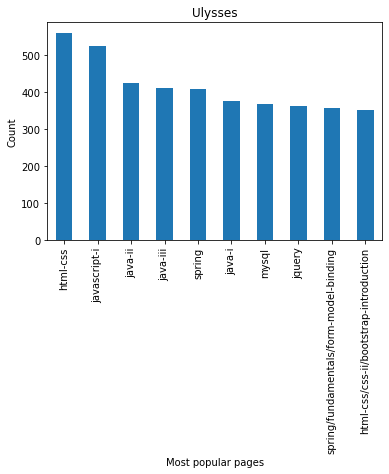

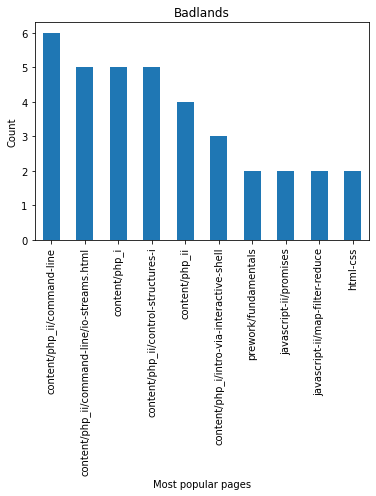

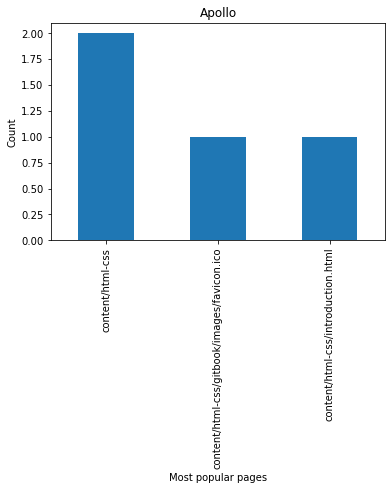

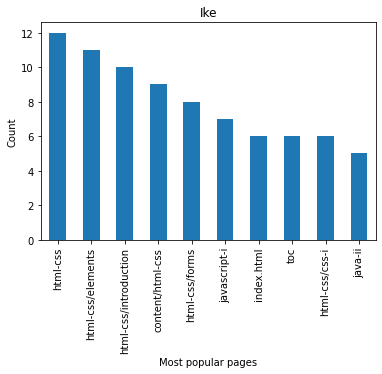

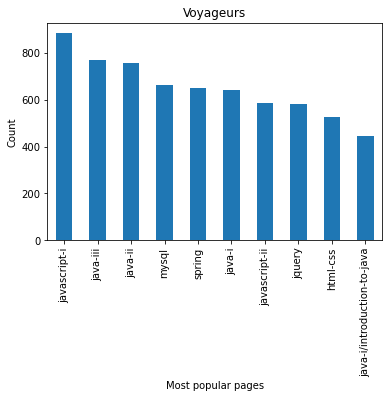

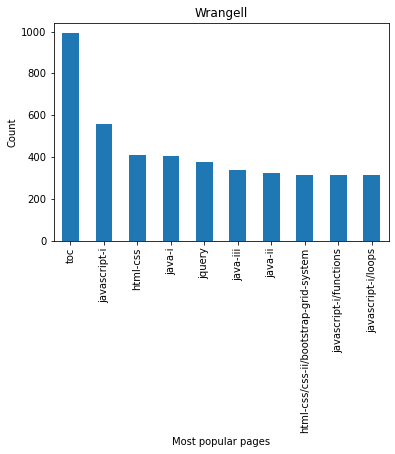

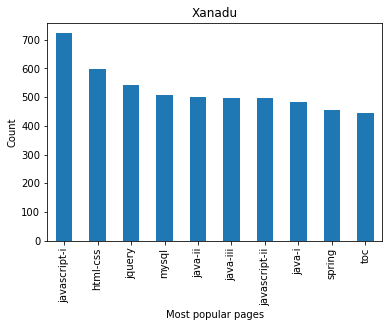

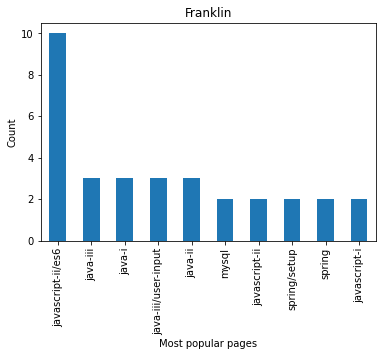

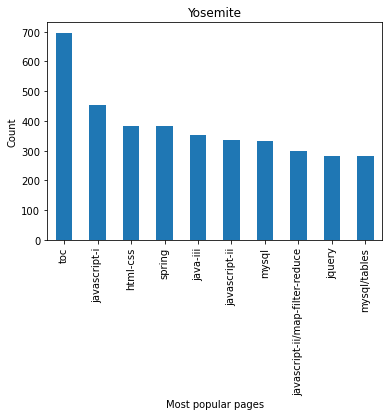

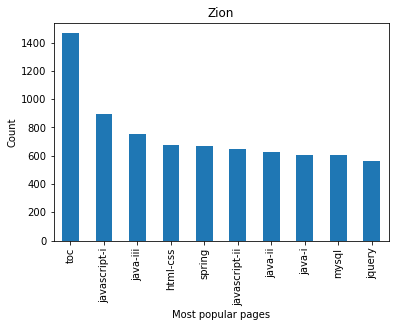

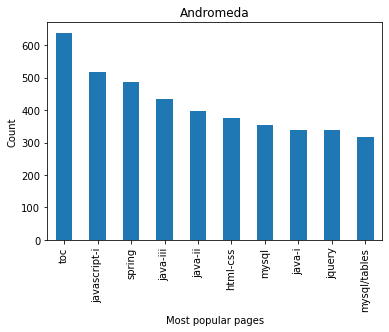

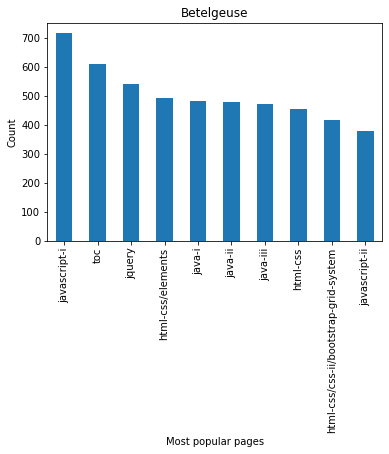

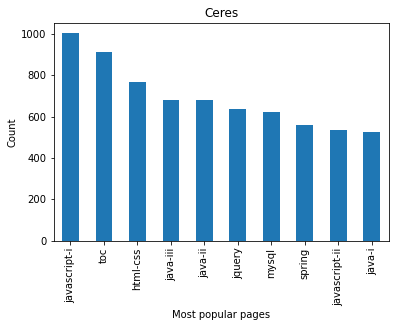

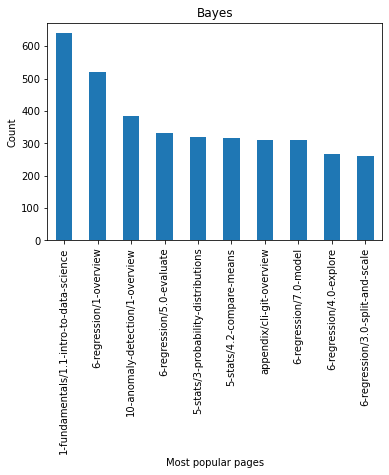

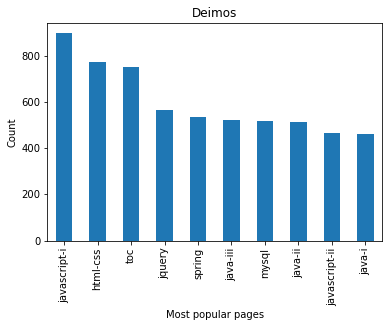

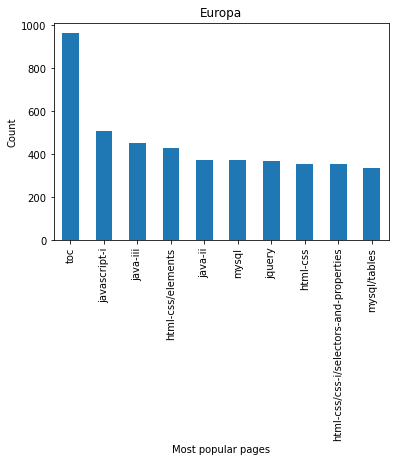

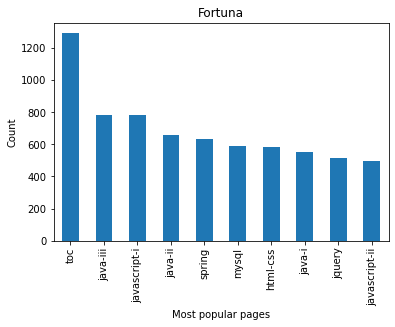

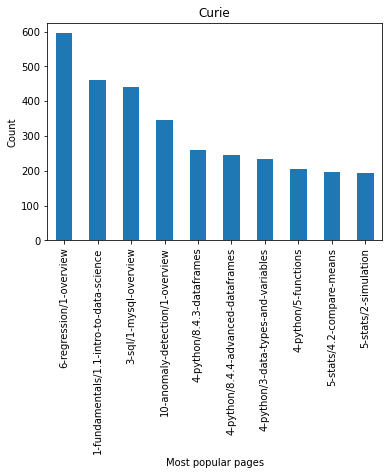

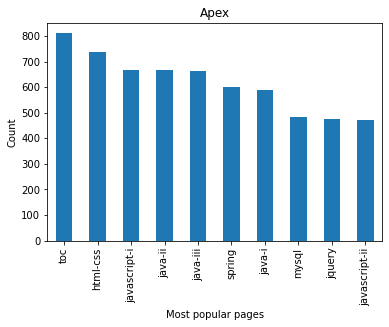

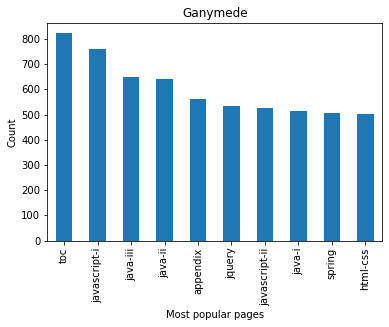

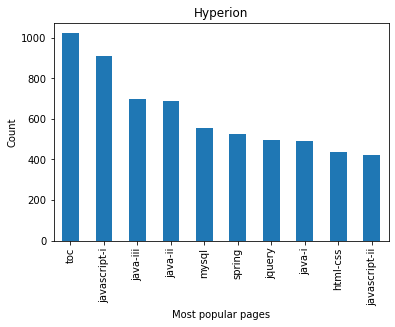

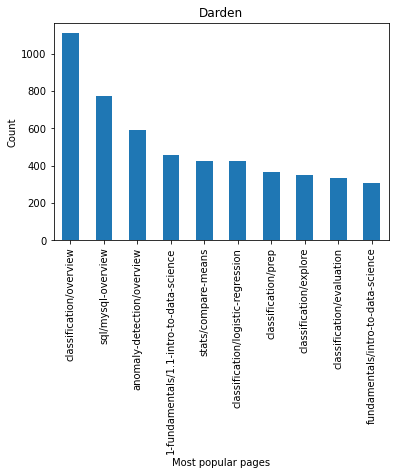

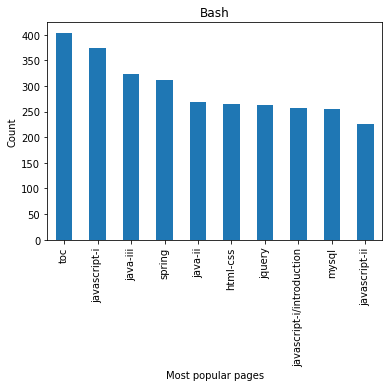

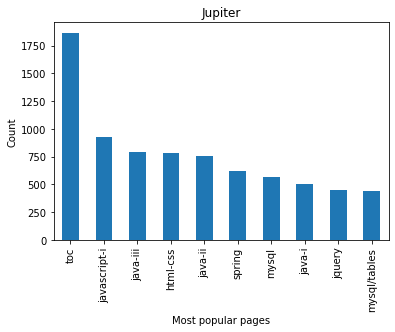

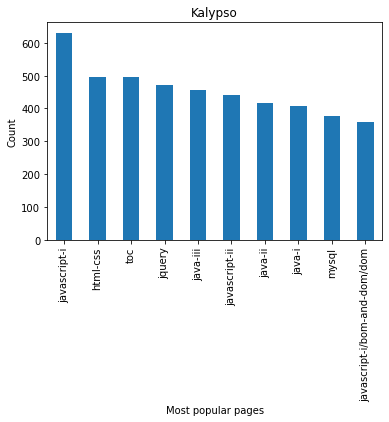

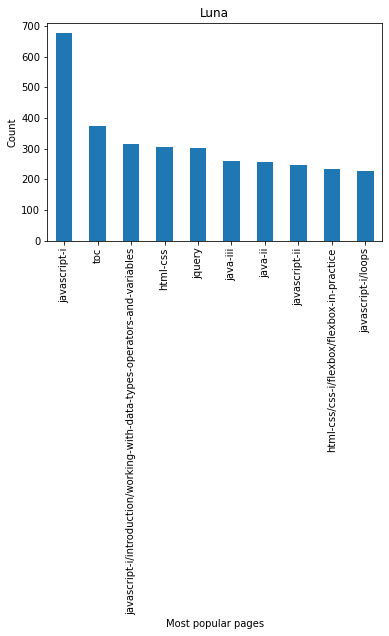

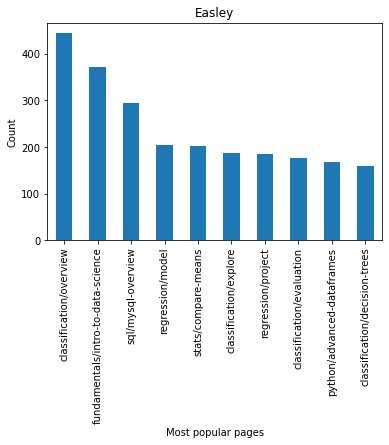

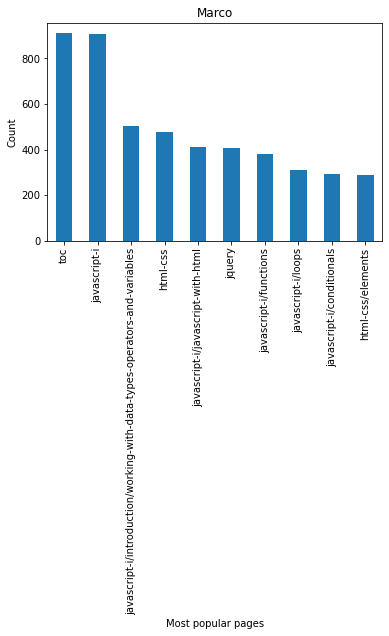

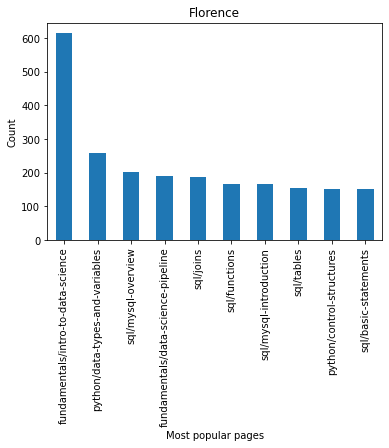

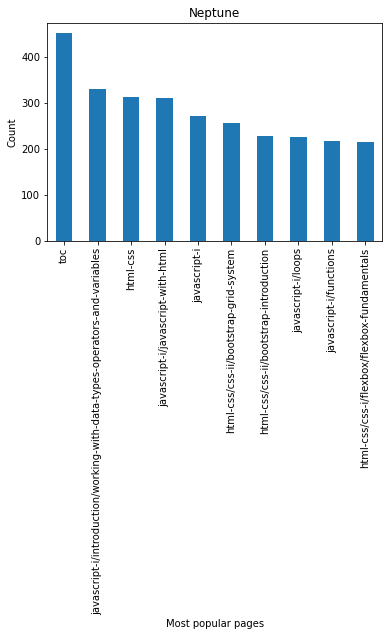

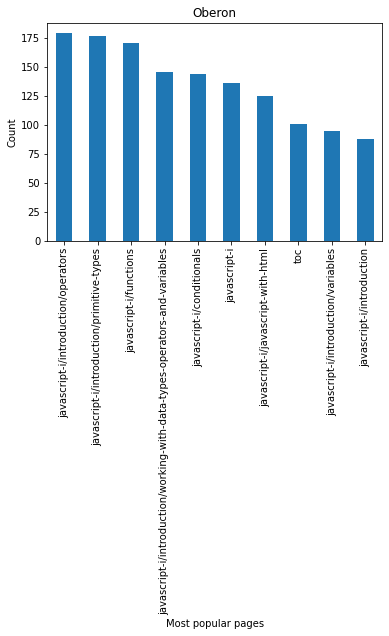

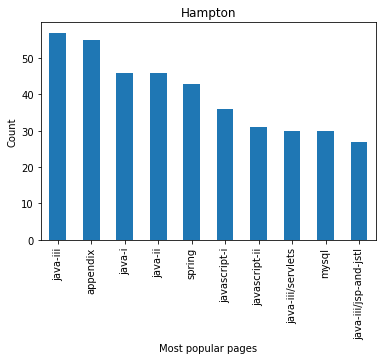

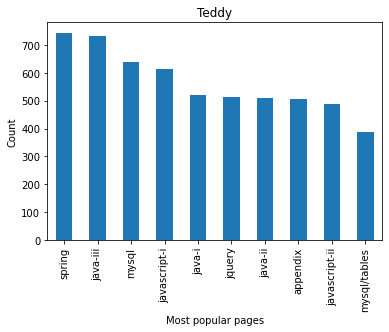

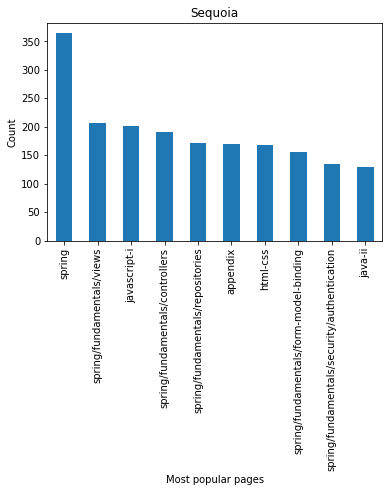

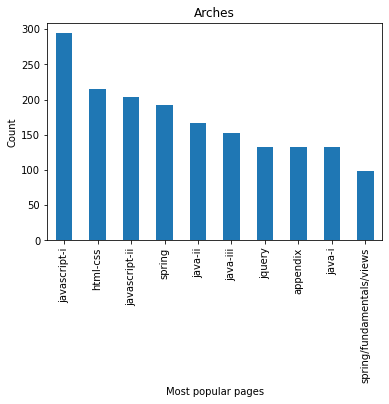

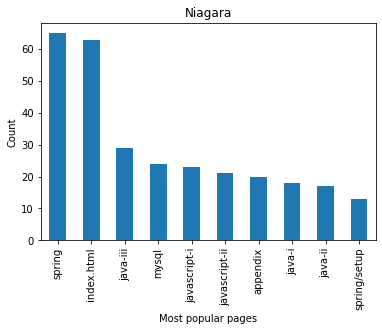

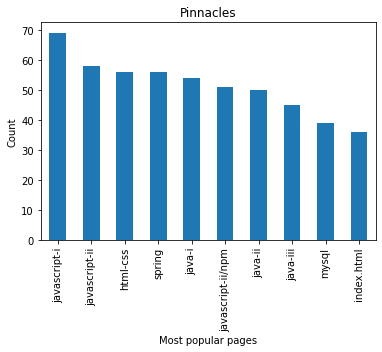

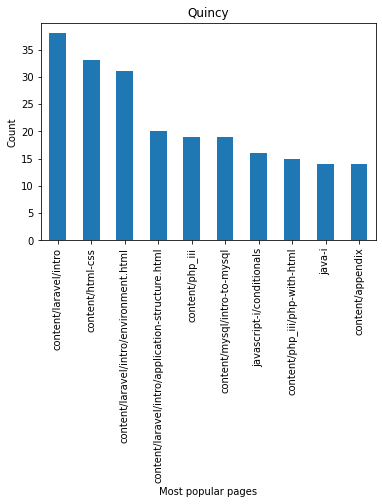

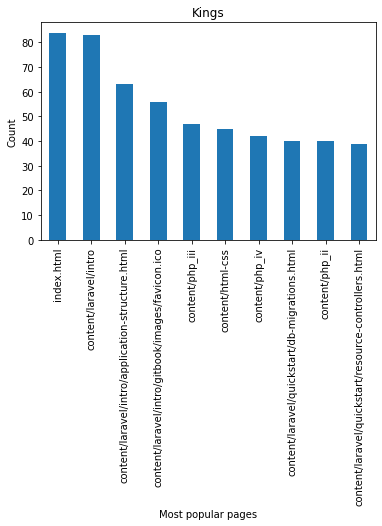

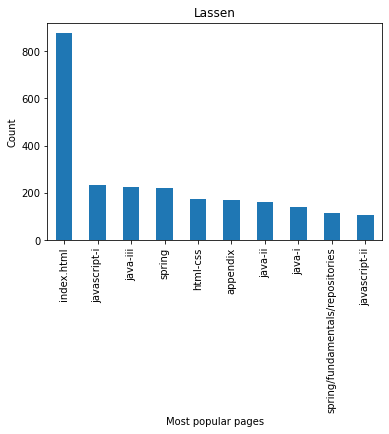

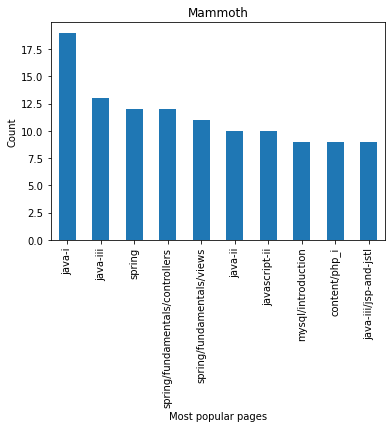

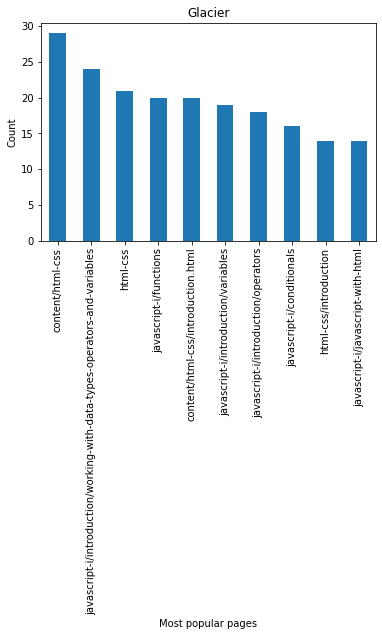

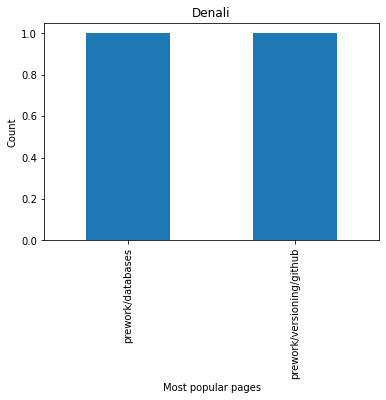

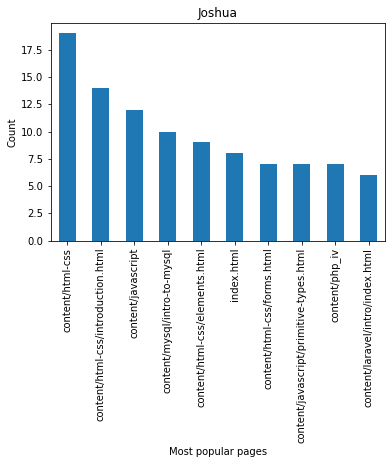

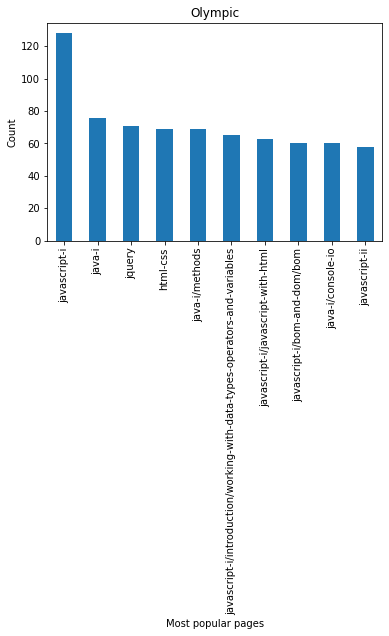

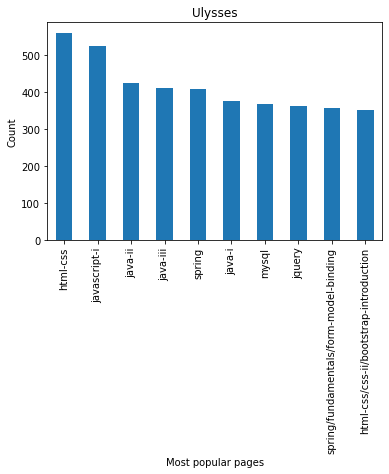

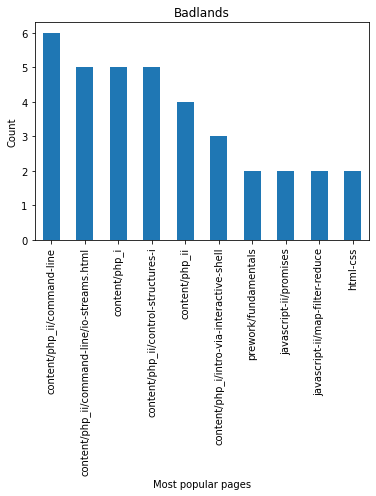

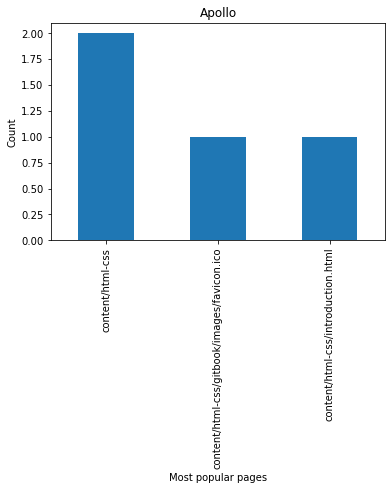

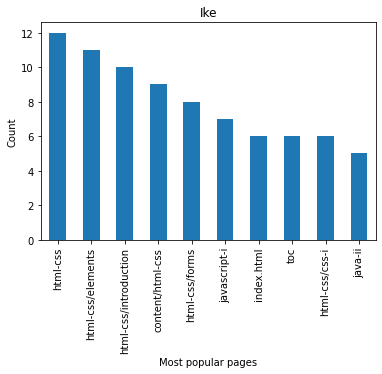

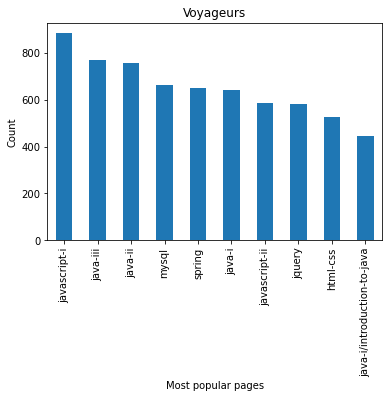

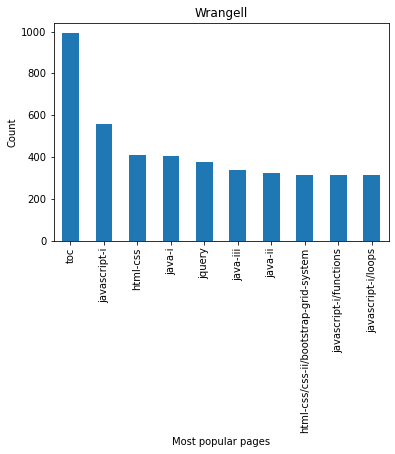

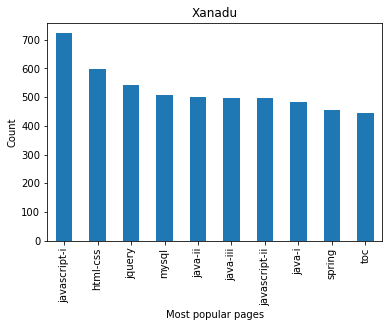

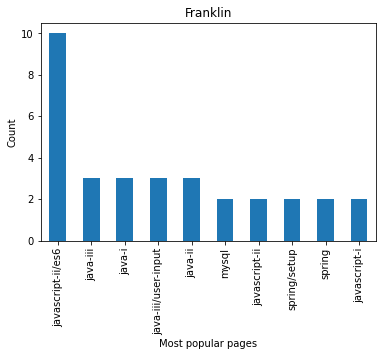

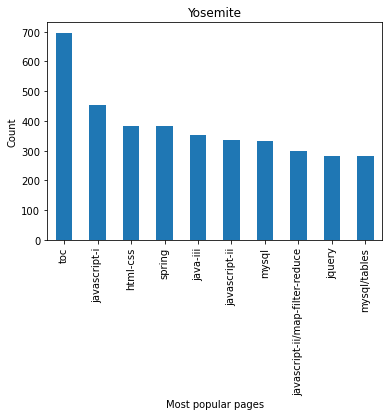

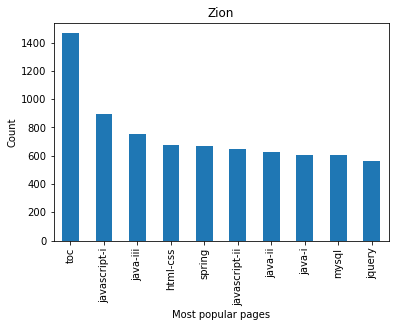

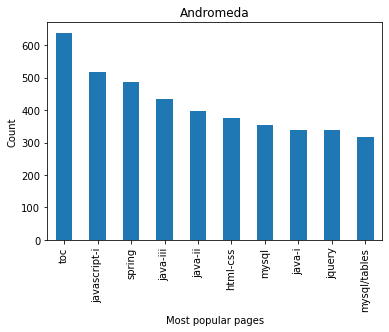

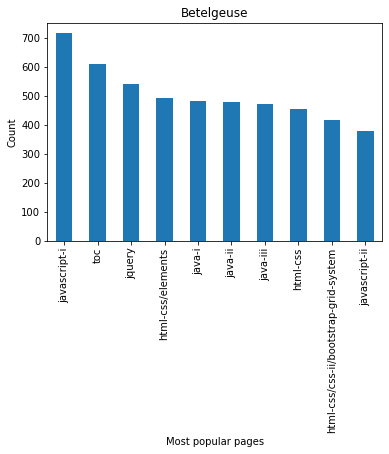

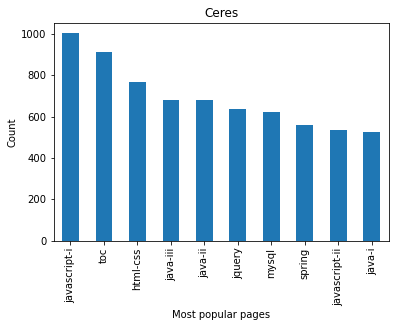

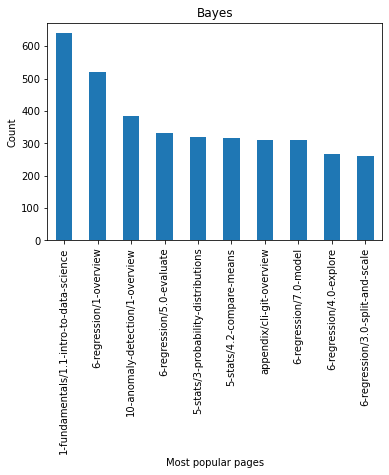

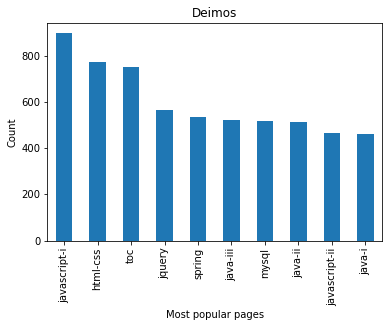

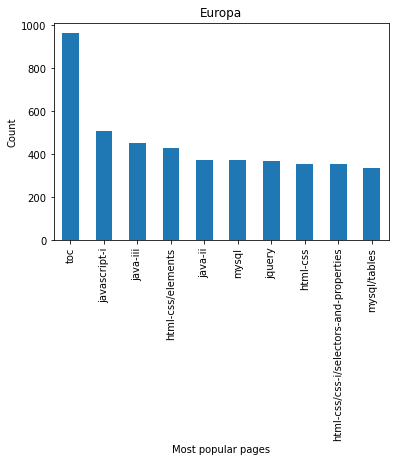

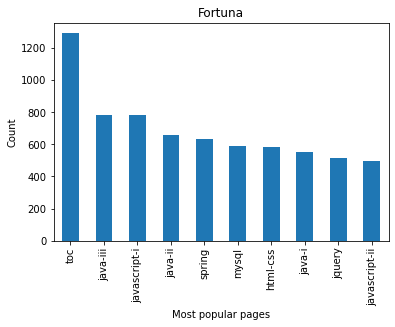

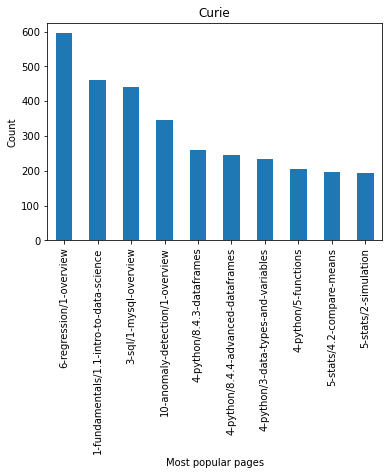

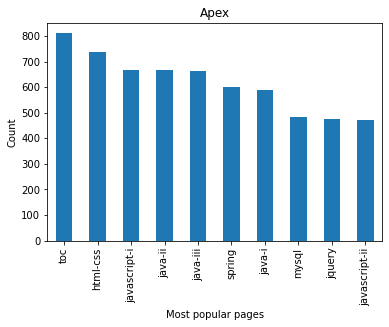

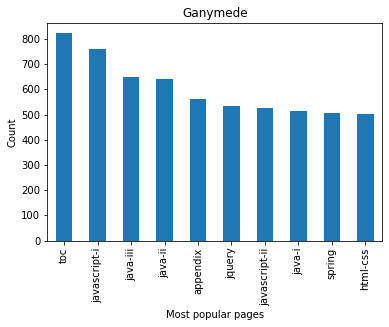

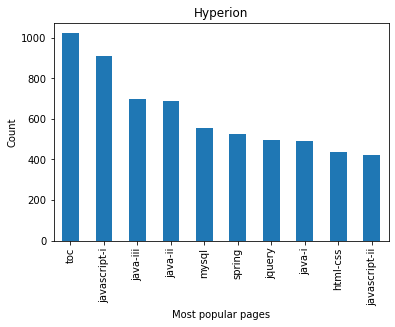

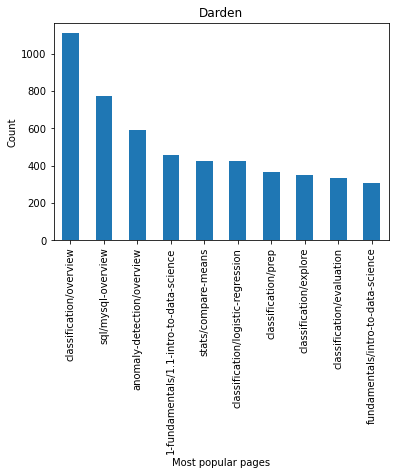

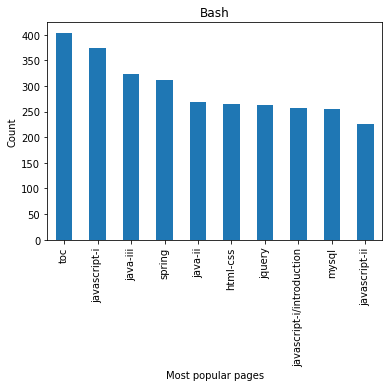

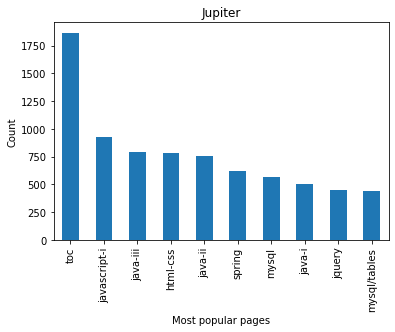

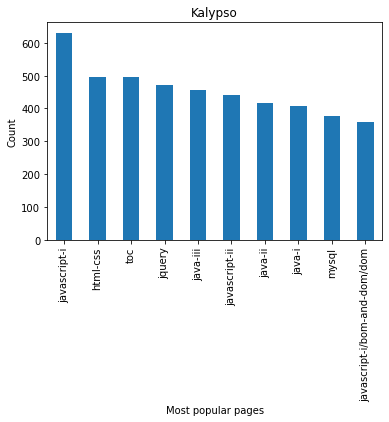

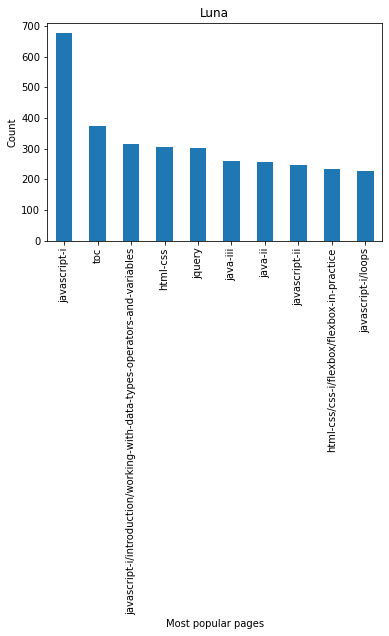

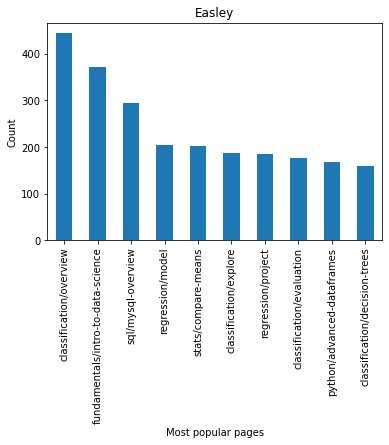

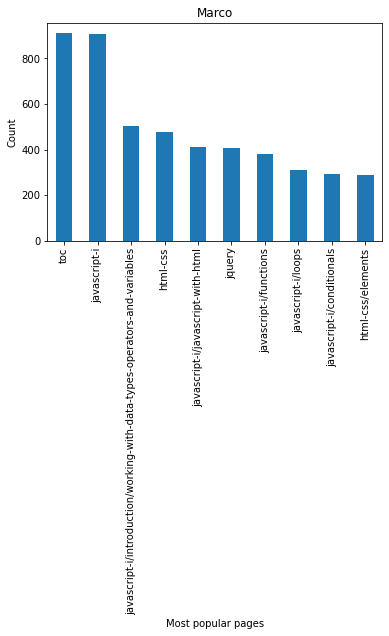

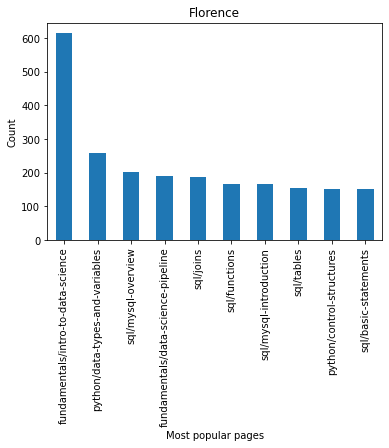

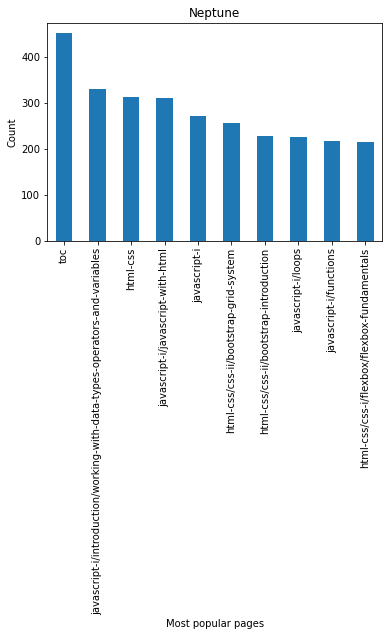

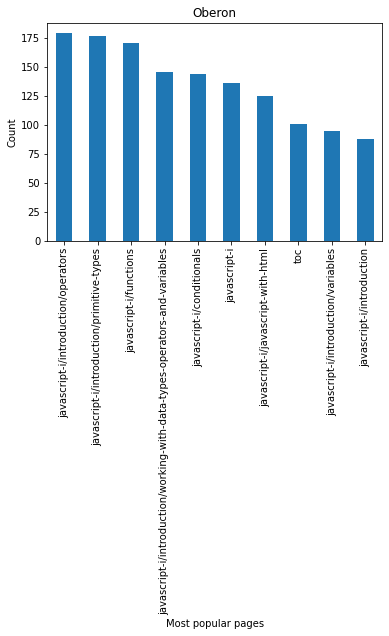

In [15]:
for program in df_dw.program_name.unique():
    plt.title(program)
    for cohort in df_dw.cohort_name.unique():
        plt.title(cohort)
        df_dw[df_dw['cohort_name'] == cohort].endpoint.value_counts().head(10).plot.bar()
        plt.xlabel('Most popular pages')
        plt.ylabel('Count')
        plt.show();


In [16]:
df_dw[df_dw['cohort_name'] == 'Teddy'].endpoint.value_counts().head(10)

spring           744
java-iii         732
mysql            638
javascript-i     615
java-i           522
jquery           512
java-ii          509
appendix         505
javascript-ii    487
mysql/tables     387
Name: endpoint, dtype: int64

In [17]:
with pd.option_context('display.max_rows', None):
    display(df_dw.groupby('endpoint').cohort_name.value_counts().to_frame())

cohort_name
endpoint                                           cohort_name             
%20https://github.com/RaulCPena                    Curie                  1
,%20https://github.com/RaulCPena                   Curie                  1
.git                                               Voyageurs              1
.gitignore                                         Darden                 1
                                                   Voyageurs              1
00_index                                           Wrangell               2
01_intro                                           Wrangell               2
02_listing_files                                   Wrangell               1
03_file_paths                                      Wrangell               1
04_navigating_the_filesystem                       Wrangell               1
05_creating_files_and_directories                  Wrangell               1
0_Classification_Algorithms                        Arches                 1
                                                   Hampton                1
1-fundamentals                                     Darden                10
1-fundamentals/1-fundamentals-overview             Voyageurs              3
                                                   Teddy                  1
                                                   Ulysses                1
                                                   Zion                   1
1-fundamentals/1.1-intro-to-data-science           Bayes                640
                                                   Curie                461
                                                   Darden               460
                                                   Florence              64
                                                   Betelgeuse             9
                                                   Easley                 8
                                                   Ceres                  7
                                                   Glacier                7
                                                   Sequoia                5
                                                   Ulysses                3
                                                   Voyageurs              3
                                                   Quincy                 2
                                                   Teddy                  2
                                                   Andromeda              1
                                                   Lassen                 1
1-fundamentals/1.2-data-science-pipeline           Darden               284
                                                   Bayes                221
                                                   Curie                146
                                                   Teddy                  4
                                                   Voyageurs              3
                                                   Andromeda              1
                                                   Betelgeuse             1
                                                   Sequoia                1
1-fundamentals/1.3-pipeline-demo                   Bayes                130
                                                   Darden               110
                                                   Curie                 60
                                                   Europa                 4
                                                   Teddy                  3
                                                   Andromeda              1
                                                   Sequoia                1
                                                   Voyageurs              1
1-fundamentals/2.1-excel-overview                  Bayes                 86
                                                   Darden                55
                                    

In [14]:
with pd.option_context('display.max_rows', None):
    counts = pd.DataFrame(df_dw.groupby('endpoint').cohort_name.value_counts())
    display(counts[counts > 1000].dropna())

cohort_name
endpoint                cohort_name             
classification/overview Darden            1109.0
javascript-i            Ceres             1003.0
toc                     Jupiter           1866.0
                        Zion              1465.0
                        Fortuna           1293.0
                        Hyperion          1022.0

In [ ]:
### The top three lessons accessed were:
#    - classification overview by darden with 1109 hits
#    - javascript - I by ceres with 1003 hits
#    - toc by jupyter and zin iwth 1866 and 1465 hits, respectively

3. Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?

In [178]:
# active students variable contains students and their activity prior to their program 
# end date and the count of their curriculum access while they were students.
active_students = df_dw[df_dw['date'] < df_dw['end_date']].groupby('user_id').endpoint.count().sort_values(ascending = True).to_frame()
active_students = active_students.reset_index()

In [179]:
# empty dataframe to hold max values of date and end date and unique user_id so we can 
# see the last dates the student accessed the curriculum while they were enrolled and prior
# to the end of their program
last_access = pd.DataFrame(columns = ('date', 'user_id', 'end_date'))

In [180]:
active_students

user_id  endpoint
0        832         2
1        278         3
2        679         4
3        539         4
4        956         4
..       ...       ...
722      555      2757
723      823      2807
724      671      2980
725      570      3921
726      344      4632

[727 rows x 2 columns]

In [181]:
# 10% least active students based on active students df count of 727
least_active_students_list = active_students.head(73)
least_active_students_list = list(least_active_students_list.user_id)
least_active_students_list

[832,
 278,
 679,
 539,
 956,
 697,
 388,
 812,
 941,
 572,
 889,
 968,
 963,
 64,
 487,
 340,
 961,
 24,
 49,
 772,
 41,
 976,
 972,
 973,
 529,
 371,
 967,
 964,
 960,
 959,
 971,
 981,
 978,
 543,
 839,
 741,
 965,
 56,
 46,
 962,
 36,
 858,
 57,
 975,
 45,
 65,
 250,
 969,
 52,
 33,
 253,
 806,
 974,
 13,
 702,
 977,
 55,
 955,
 734,
 958,
 954,
 929,
 431,
 249,
 342,
 957,
 432,
 833,
 22,
 945,
 970,
 28,
 251]

In [183]:
least_active_activity = df_dw[(df_dw['user_id'].isin(least_active_students_list))].sort_values(by = 'user_id')
least_active_activity.user_id.nunique()

73

In [185]:
for user in least_active_activity.user_id.unique():
    # dictinary used in for loop to store values we want to append to last_access df
    a_df = {'date':max(least_active_activity[least_active_activity['user_id'] == user].index), 'user_id':user, 'end_date':max(least_active_activity[least_active_activity['user_id'] == user].end_date)}
    last_access = last_access.append(a_df, ignore_index = True)
        
last_access[last_access.date < last_access.end_date].sample(20)

date user_id   end_date
54 2021-04-21     960 2021-10-01
34 2020-08-03     702 2021-01-21
33 2020-07-13     697 2021-01-12
70 2021-04-21     977 2021-10-01
7  2018-02-05      45 2018-02-15
43 2021-01-28     858 2021-05-04
63 2021-04-21     970 2021-10-01
14 2020-01-21      64 2020-04-17
42 2020-12-14     839 2021-06-08
61 2021-04-20     968 2021-10-01
64 2021-04-20     971 2021-10-01
51 2021-04-21     957 2021-10-01
27 2019-08-30     487 2020-01-30
72 2021-04-21     981 2021-09-03
48 2021-04-21     954 2021-10-01
45 2021-04-21     929 2021-09-03
65 2021-04-21     972 2021-10-01
22 2019-01-28     342 2019-06-04
57 2021-04-20     963 2021-10-01
66 2021-04-21     973 2021-10-01

In [187]:
last_access.shape

(73, 3)

4. Is there any suspicious activity, such as users/machines/etc. accessing the curriculum who shouldn't be? Does it appear that any web-scraping is happening? Are there any suspicious IP addresses?

In [210]:
# let's pull the ip addresses of Staff and take them out of the dataframe to identify other
# users accessing the curriculum
df_ip = pd.read_csv('curriculum_logs.csv')
staff_ip = list(df_ip[df_ip['name'] == 'Staff'].ip.unique())
len(staff_ip)

318

In [215]:
# nonstaff_ip is a df without the ip addresses of users who accessed the curriculum and are
# classified as staff
nonstaff_ip = df_dw[~df_dw['source_ip'].isin(staff_ip)]

In [241]:
with pd.option_context('display.max_rows', None):
    ip_counts = pd.DataFrame(nonstaff_ip.groupby('source_ip').user_id.value_counts())
    display(ip_counts[ip_counts > 500].dropna())

user_id
source_ip       user_id         
104.10.49.137   613       2441.0
104.190.242.24  635       1207.0
104.190.242.242 20        1439.0
104.219.136.34  733        897.0
104.48.213.175  120       1034.0
107.128.2.166   655       1187.0
107.140.16.45   880       1341.0
107.140.217.8   648       1298.0
107.192.148.199 763       1296.0
107.198.56.204  600       1511.0
107.204.50.40   323        509.0
107.204.53.83   768        630.0
108.199.117.235 524       1330.0
108.200.131.128 551        570.0
108.239.188.205 681        938.0
                781        502.0
108.95.37.118   756        688.0
130.45.47.56    590        598.0
130.45.49.89    851        586.0
130.45.76.131   789       1102.0
136.50.17.203   621       1133.0
136.50.18.71    374        578.0
136.50.32.151   555       2266.0
136.50.55.44    795        537.0
136.50.56.155   680        860.0
136.50.64.245   579        533.0
136.50.67.16    796       1239.0
136.50.70.27    699       1088.0
136.50.70.48    705       1284.0
136.50.74.48    632       1550.0
136.50.98.51    869        577.0
148.66.39.72    845       1435.0
148.66.39.89    662       1803.0
162.195.131.242 799       1234.0
162.197.239.66  695        714.0
162.229.67.41   598        618.0
172.124.67.93   570       2449.0
                571        910.0
172.124.70.146  526        587.0
172.125.226.175 771       1660.0
172.14.176.83   612       1840.0
172.9.1.31      556        632.0
173.172.202.149 708        549.0
173.173.109.5   835        746.0
173.173.110.195 761       1456.0
173.174.130.38  643       1038.0
173.174.142.84  485        889.0
173.174.190.7   642        788.0
173.174.200.226 268        724.0
173.174.211.206 344        993.0
173.174.219.75  631        969.0
173.174.253.193 269        508.0
173.175.108.125 788       1711.0
174.48.18.249   794       1424.0
174.67.1.123    614       1397.0
216.1.153.162   68         822.0
216.63.31.195   595       2285.0
23.122.43.83    622       1402.0
24.160.0.250    759       1471.0
24.160.7.8      844        782.0
24.243.12.201   776       1302.0
24.243.22.116   849        510.0
24.243.49.105   669        577.0
24.243.67.104   671       3016.0
24.26.242.224   633        974.0
24.26.249.215   585        660.0
24.55.13.37     822        825.0
32.141.17.86    604        670.0
45.20.117.105   554        652.0
45.20.118.158   750       1347.0
45.26.146.156   639       1157.0
47.184.206.205  701        708.0
47.187.240.67   602       1351.0
47.187.244.53   615        748.0
47.188.176.59   751        937.0
47.188.180.229  751        533.0
50.30.92.22     660        859.0
64.124.32.82    604       1041.0
64.250.9.181    617        674.0
65.43.116.84    670       1042.0
66.196.21.182   823       2493.0
66.25.163.122   644       1444.0
66.69.1.31      804        523.0
66.69.108.117   347       1176.0
66.69.219.165   807        540.0
66.69.79.82     837        598.0
66.69.83.140    691        675.0
67.10.140.180   808        669.0
67.10.152.210   657        804.0
67.10.161.55    53         645.0
67.10.166.10    435        654.0
67.11.136.146   566       2100.0
67.11.138.20    640       1269.0
67.11.157.190   410        794.0
67.11.211.115   641       1485.0
67.11.239.2     274        675.0
67.11.243.229   801       1194.0
67.11.245.224   794       1330.0
67.11.48.186    873        501.0
67.11.50.23     834       2277.0
                672       1659.0
67.11.56.110    656       1176.0
67.11.85.236    696        879.0
68.201.233.142  892        649.0
68.203.188.247  730        731.0
68.203.194.78   667       1353.0
68.206.160.201  887        997.0
68.206.165.118  531        782.0
68.54.110.249   682        854.0
69.208.245.166  802        572.0
69.213.15.192   599        549.0
69.231.76.212   606        757.0
69.231.92.35    582        638.0
69.58.156.212   765        852.0
69.91.64.132    804        606.0
70.112.103.21   547        846.0
70.114.0.52     638       1523.0
70.115.90.106   609        525.0
70.117.16.40    495        721.0
70.120.16.59    684        662.0

In [225]:
max(df_dw[df_dw['user_id'] == 613].index) - min(df_dw[df_dw['user_id'] == 613].index)

Timedelta('395 days 00:00:00')

In [246]:
# unique ip by user is ip counts with hits greater than 500.
unique_ip_by_user = ip_counts[ip_counts > 500].dropna()
# user_ip_count is a new column so that we can then sort values by the count and get the 
# ip addresses with the most hits
unique_ip_by_user['user_ip_count'] = ip_counts[ip_counts > 500].dropna()
# top three users with the most ip calls that could potentially be suspicious
unique_ip_by_user.sort_values(by = 'user_ip_count').tail(3)

user_id  user_ip_count
source_ip     user_id                        
99.76.233.212 685       2531.0         2531.0
72.190.174.52 764       2602.0         2602.0
24.243.67.104 671       3016.0         3016.0

In [247]:
df_dw[df_dw['user_id'] == 685]

date      time                                  endpoint  \
date                                                                        
2020-07-14 2020-07-14  11:09:36  1-fundamentals/1.1-intro-to-data-science   
2020-07-14 2020-07-14  11:13:12  1-fundamentals/1.2-data-science-pipeline   
2020-07-14 2020-07-14  16:09:56  1-fundamentals/1.1-intro-to-data-science   
2020-07-14 2020-07-14  17:09:38  1-fundamentals/1.1-intro-to-data-science   
2020-07-14 2020-07-14  17:09:40                 1.2-data-science-pipeline   
...               ...       ...                                       ...   
2021-04-19 2021-04-19  17:07:44                            sql/subqueries   
2021-04-19 2021-04-19  17:07:57                       sql/case-statements   
2021-04-19 2021-04-19  17:08:03                      sql/temporary-tables   
2021-04-19 2021-04-19  17:08:58                                 sql/joins   
2021-04-19 2021-04-19  18:14:01                            sql/subqueries   

            user_id  cohort_id      source_ip cohort_name start_date  \
date                                                                   
2020-07-14      685       59.0  99.76.233.212      Darden 2020-07-13   
2020-07-14      685       59.0  99.76.233.212      Darden 2020-07-13   
2020-07-14      685       59.0  99.76.233.212      Darden 2020-07-13   
2020-07-14      685       59.0  99.76.233.212      Darden 2020-07-13   
2020-07-14      685       59.0  99.76.233.212      Darden 2020-07-13   
...             ...        ...            ...         ...        ...   
2021-04-19      685       59.0  99.76.233.212      Darden 2020-07-13   
2021-04-19      685       59.0  99.76.233.212      Darden 2020-07-13   
2021-04-19      685       59.0  99.76.233.212      Darden 2020-07-13   
2021-04-19      685       59.0  99.76.233.212      Darden 2020-07-13   
2021-04-19      685       59.0  99.76.233.212      Darden 2020-07-13   

             end_date          created_at           updated_at  program_id  \
date                                                                         
2020-07-14 2021-01-12 2020-07-13 18:32:19  2020-07-13 18:32:19         3.0   
2020-07-14 2021-01-12 2020-07-13 18:32:19  2020-07-13 18:32:19         3.0   
2020-07-14 2021-01-12 2020-07-13 18:32:19  2020-07-13 18:32:19         3.0   
2020-07-14 2021-01-12 2020-07-13 18:32:19  2020-07-13 18:32:19         3.0   
2020-07-14 2021-01-12 2020-07-13 18:32:19  2020-07-13 18:32:19         3.0   
...               ...                 ...                  ...         ...   
2021-04-19 2021-01-12 2020-07-13 18:32:19  2020-07-13 18:32:19         3.0   
2021-04-19 2021-01-12 2020-07-13 18:32:19  2020-07-13 18:32:19         3.0   
2021-04-19 2021-01-12 2020-07-13 18:32:19  2020-07-13 18:32:19         3.0   
2021-04-19 2021-01-12 2020-07-13 18:32:19  2020-07-13 18:32:19         3.0   
2021-04-19 2021-01-12 2020-07-13 18:32:19  2020-07-13 18:32:19         3.0   

                     date_time  program_name        course  
date                                                        
2020-07-14 2020-07-14 11:09:36  Data Science  Data Science  
2020-07-14 2020-07-14 11:13:12  Data Science  Data Science  
2020-07-14 2020-07-14 16:09:56  Data Science  Data Science  
2020-07-14 2020-07-14 17:09:38  Data Science  Data Science  
2020-07-14 2020-07-14 17:09:40  Data Science  Data Science  
...                        ...           ...           ...  
2021-04-19 2021-04-19 17:07:44  Data Science  Data Science  
2021-04-19 2021-04-19 17:07:57  Data Science  Data Science  
2021-04-19 2021-04-19 17:08:03  Data Science  Data Science  
2021-04-19 2021-04-19 17:08:58  Data Science  Data Science  
2021-04-19 2021-04-19 18:14:01  Data Science  Data Science  

[2551 rows x 15 columns]

In [251]:
max(df_dw[df_dw['user_id'] == 685].index) - min(df_dw[df_dw['user_id'] == 685].index)

Timedelta('279 days 00:00:00')

In [248]:
df_dw[df_dw['user_id'] == 764]

date      time                     endpoint  user_id  \
date                                                                    
2020-09-21 2020-09-21  15:46:30                          toc      764   
2020-09-21 2020-09-21  15:46:42                          toc      764   
2020-09-21 2020-09-21  22:32:43                          toc      764   
2020-09-21 2020-09-21  23:39:16                          toc      764   
2020-09-21 2020-09-21  23:39:18                          toc      764   
...               ...       ...                          ...      ...   
2021-04-06 2021-04-06  18:56:06                    job-board      764   
2021-04-09 2021-04-09  07:31:11  slides/introduction_to_java      764   
2021-04-09 2021-04-09  21:14:27  slides/introduction_to_java      764   
2021-04-11 2021-04-11  17:27:02                          toc      764   
2021-04-15 2021-04-15  08:57:24          java-ii/collections      764   

            cohort_id      source_ip cohort_name start_date   end_date  \
date                                                                     
2020-09-21       62.0  72.190.174.52     Jupiter 2020-09-21 2021-03-30   
2020-09-21       62.0  72.190.174.52     Jupiter 2020-09-21 2021-03-30   
2020-09-21       62.0  72.190.174.52     Jupiter 2020-09-21 2021-03-30   
2020-09-21       62.0  72.190.174.52     Jupiter 2020-09-21 2021-03-30   
2020-09-21       62.0  72.190.174.52     Jupiter 2020-09-21 2021-03-30   
...               ...            ...         ...        ...        ...   
2021-04-06       62.0  72.190.174.52     Jupiter 2020-09-21 2021-03-30   
2021-04-09       62.0  72.190.174.52     Jupiter 2020-09-21 2021-03-30   
2021-04-09       62.0  72.190.174.52     Jupiter 2020-09-21 2021-03-30   
2021-04-11       62.0  72.190.174.52     Jupiter 2020-09-21 2021-03-30   
2021-04-15       62.0  72.190.174.52     Jupiter 2020-09-21 2021-03-30   

                    created_at           updated_at  program_id  \
date                                                              
2020-09-21 2020-09-21 18:06:27  2020-09-21 18:06:27         2.0   
2020-09-21 2020-09-21 18:06:27  2020-09-21 18:06:27         2.0   
2020-09-21 2020-09-21 18:06:27  2020-09-21 18:06:27         2.0   
2020-09-21 2020-09-21 18:06:27  2020-09-21 18:06:27         2.0   
2020-09-21 2020-09-21 18:06:27  2020-09-21 18:06:27         2.0   
...                        ...                  ...         ...   
2021-04-06 2020-09-21 18:06:27  2020-09-21 18:06:27         2.0   
2021-04-09 2020-09-21 18:06:27  2020-09-21 18:06:27         2.0   
2021-04-09 2020-09-21 18:06:27  2020-09-21 18:06:27         2.0   
2021-04-11 2020-09-21 18:06:27  2020-09-21 18:06:27         2.0   
2021-04-15 2020-09-21 18:06:27  2020-09-21 18:06:27         2.0   

                     date_time                     program_name  \
date                                                              
2020-09-21 2020-09-21 15:46:30  Java Full Stack Web Development   
2020-09-21 2020-09-21 15:46:42  Java Full Stack Web Development   
2020-09-21 2020-09-21 22:32:43  Java Full Stack Web Development   
2020-09-21 2020-09-21 23:39:16  Java Full Stack Web Development   
2020-09-21 2020-09-21 23:39:18  Java Full Stack Web Development   
...                        ...                              ...   
2021-04-06 2021-04-06 18:56:06  Java Full Stack Web Development   
2021-04-09 2021-04-09 07:31:11  Java Full Stack Web Development   
2021-04-09 2021-04-09 21:14:27  Java Full Stack Web Development   
2021-04-11 2021-04-11 17:27:02  Java Full Stack Web Development   
2021-04-15 2021-04-15 08:57:24  Java Full Stack Web Development   

                     course  
date                         
2020-09-21  Web Development  
2020-09-21  Web Development  
2020-09-21  Web Development  
2020-09-21  Web Development  
2020-09-21  Web Development  
...                     ...  
2021-04-06  Web Development  
2021-04-09  Web Development  
2021-04-09  Web Development  
2021-04-11  Web Development  


In [252]:
max(df_dw[df_dw['user_id'] == 764].index) - min(df_dw[df_dw['user_id'] == 764].index)

Timedelta('206 days 00:00:00')

In [249]:
df_dw[df_dw['user_id'] == 671]

date      time  \
date                              
2020-05-27 2020-05-27  09:14:34   
2020-05-27 2020-05-27  09:30:54   
2020-05-27 2020-05-27  09:33:40   
2020-05-27 2020-05-27  09:58:46   
2020-05-27 2020-05-27  11:09:30   
...               ...       ...   
2020-11-27 2020-11-27  10:25:36   
2020-12-24 2020-12-24  10:58:37   
2020-12-24 2020-12-24  10:58:41   
2020-12-24 2020-12-24  10:58:43   
2020-12-24 2020-12-24  10:58:48   

                                                     endpoint  user_id  \
date                                                                     
2020-05-27                                           html-css      671   
2020-05-27                                                toc      671   
2020-05-27                                           html-css      671   
2020-05-27                                           html-css      671   
2020-05-27                              html-css/introduction      671   
...                                                       ...      ...   
2020-11-27  appendix/professional-development/professional...      671   
2020-12-24                                           appendix      671   
2020-12-24                                           appendix      671   
2020-12-24                                           capstone      671   
2020-12-24                                  capstone/workbook      671   

            cohort_id      source_ip cohort_name start_date   end_date  \
date                                                                     
2020-05-27       58.0  24.243.67.104    Hyperion 2020-05-26 2020-11-10   
2020-05-27       58.0  24.243.67.104    Hyperion 2020-05-26 2020-11-10   
2020-05-27       58.0  24.243.67.104    Hyperion 2020-05-26 2020-11-10   
2020-05-27       58.0  24.243.67.104    Hyperion 2020-05-26 2020-11-10   
2020-05-27       58.0  24.243.67.104    Hyperion 2020-05-26 2020-11-10   
...               ...            ...         ...        ...        ...   
2020-11-27       58.0  24.243.67.104    Hyperion 2020-05-26 2020-11-10   
2020-12-24       58.0  24.243.67.104    Hyperion 2020-05-26 2020-11-10   
2020-12-24       58.0  24.243.67.104    Hyperion 2020-05-26 2020-11-10   
2020-12-24       58.0  24.243.67.104    Hyperion 2020-05-26 2020-11-10   
2020-12-24       58.0  24.243.67.104    Hyperion 2020-05-26 2020-11-10   

                    created_at           updated_at  program_id  \
date                                                              
2020-05-27 2020-05-26 19:22:44  2020-05-26 19:22:44         2.0   
2020-05-27 2020-05-26 19:22:44  2020-05-26 19:22:44         2.0   
2020-05-27 2020-05-26 19:22:44  2020-05-26 19:22:44         2.0   
2020-05-27 2020-05-26 19:22:44  2020-05-26 19:22:44         2.0   
2020-05-27 2020-05-26 19:22:44  2020-05-26 19:22:44         2.0   
...                        ...                  ...         ...   
2020-11-27 2020-05-26 19:22:44  2020-05-26 19:22:44         2.0   
2020-12-24 2020-05-26 19:22:44  2020-05-26 19:22:44         2.0   
2020-12-24 2020-05-26 19:22:44  2020-05-26 19:22:44         2.0   
2020-12-24 2020-05-26 19:22:44  2020-05-26 19:22:44         2.0   
2020-12-24 2020-05-26 19:22:44  2020-05-26 19:22:44         2.0   

                     date_time                     program_name  \
date                                                              
2020-05-27 2020-05-27 09:14:34  Java Full Stack Web Development   
2020-05-27 2020-05-27 09:30:54  Java Full Stack Web Development   
2020-05-27 2020-05-27 09:33:40  Java Full Stack Web Development   
2020-05-27 2020-05-27 09:58:46  Java Full Stack Web Development   
2020-05-27 2020-05-27 11:09:30  Java Full Stack Web Development   
...                        ...                              ...   
2020-11-27 2020-11-27 10:25:36  Java Full Stack Web Development   
2020-12-24 2020-12-24 10:58:37  Java Full Stack Web Development   
2020-12-24 2020-12-24 10:58:41  Java Full Stack Web Development   
2020-12-24 2020-12-24 10:5

In [253]:
max(df_dw[df_dw['user_id'] == 671].index) - min(df_dw[df_dw['user_id'] == 671].index)

Timedelta('211 days 00:00:00')

In [254]:
# let's check the number of unique values for updated_at
df_dw['updated_at'].nunique()

36

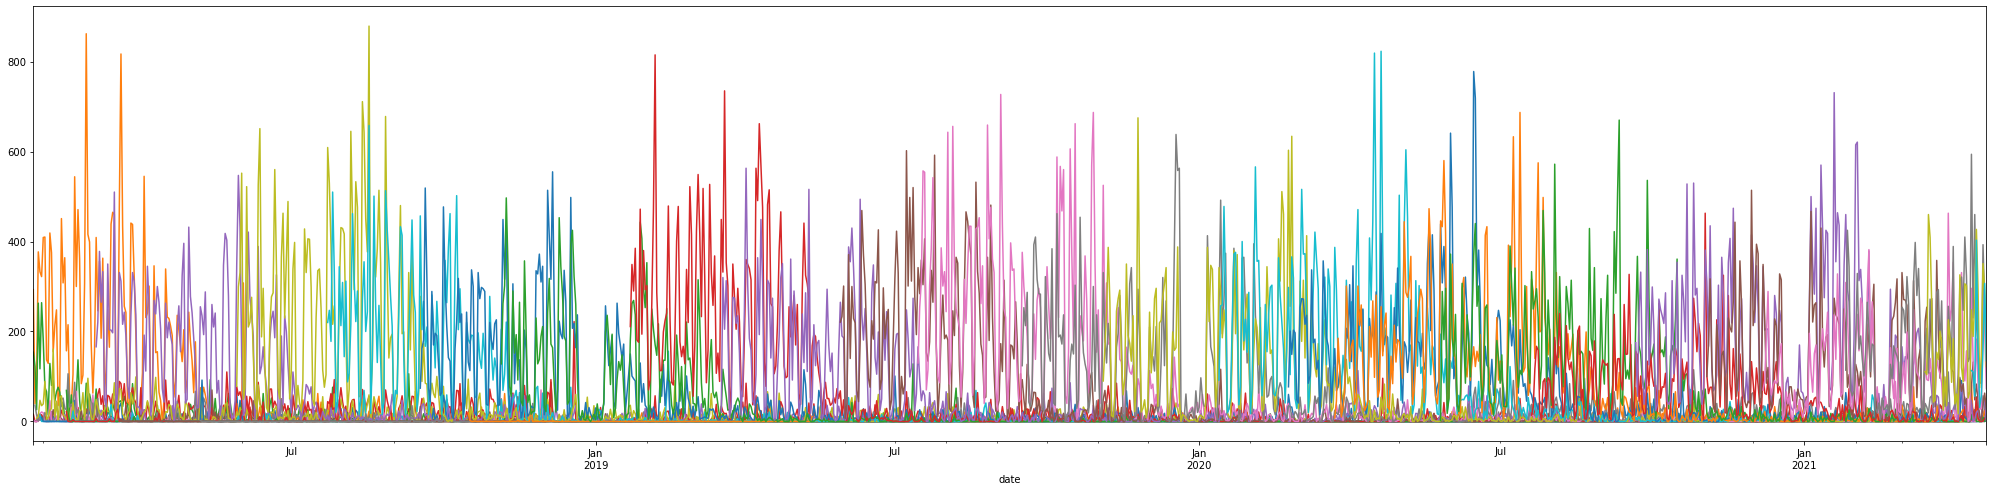

In [279]:
for cohort in df_dw[df_dw['course'] == 'Web Development'].cohort_name.unique():
    df_dw[df_dw['cohort_name'] == cohort].resample('D').endpoint.count().plot(figsize = (35,8))

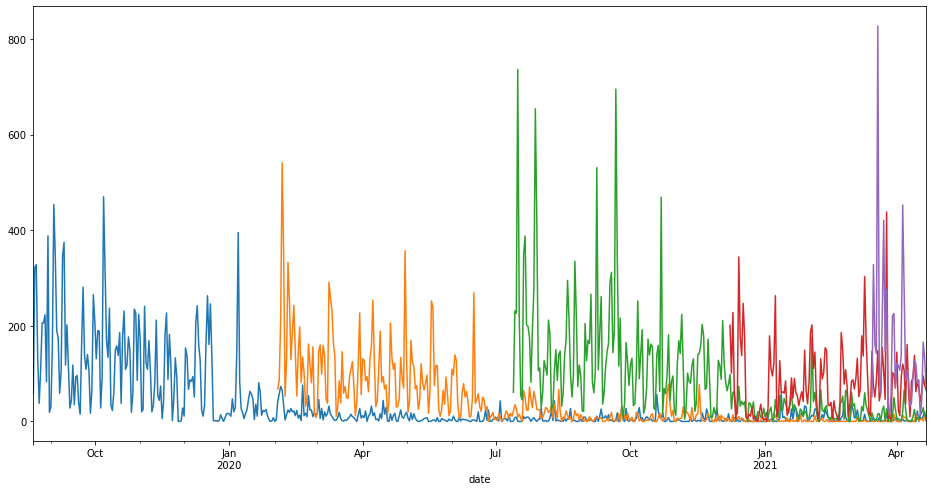

In [277]:
for cohort in df_dw[df_dw['course'] == 'Data Science'].cohort_name.unique():
    df_dw[df_dw['cohort_name'] == cohort].resample('D').endpoint.count().plot(figsize = (16,8))

In [274]:
df_dw[df_dw['course'] == 'Data Science'].cohort_name

date
2019-08-20     Bayes
2019-08-20     Bayes
2019-08-20     Bayes
2019-08-20     Bayes
2019-08-20     Bayes
               ...  
2021-04-21    Easley
2021-04-21    Easley
2021-04-21    Easley
2021-04-21    Easley
2021-04-21    Easley
Name: cohort_name, Length: 79180, dtype: object

5. At some point in 2019, the ability for students and alumni to access both curriculums (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before?

In [ ]:
# waiting on Alejandro's notebook to be pushed with 5 answered

In [33]:
post_2018 = df_dw[df_dw.index >= '2019-01-01']

In [34]:
ds_students = df_dw[df_dw['course'] == 'Data Science']
wb_students = df_dw[df_dw['course'] == 'Web Development']

In [35]:
ds_students[ds_students['user_id'].isin(user_id_inst)]

date      time                      endpoint  user_id  \
date                                                                     
2019-08-30 2019-08-30  12:02:11          appendix/cli/1-intro      487   
2019-08-30 2019-08-30  12:11:10  appendix/cli/2-listing-files      487   
2019-08-30 2019-08-30  13:37:40       appendix/cli/0-overview      487   
2019-08-30 2019-08-30  13:37:58     appendix/cli-git-overview      487   
2019-08-30 2019-08-30  14:12:22     appendix/cli/3-file-paths      487   
...               ...       ...                           ...      ...   
2021-04-21 2021-04-21  11:11:42             python/dataframes      902   
2021-04-21 2021-04-21  11:12:29             python/dataframes      902   
2021-04-21 2021-04-21  11:12:33                 python/series      902   
2021-04-21 2021-04-21  11:12:51             python/dataframes      902   
2021-04-21 2021-04-21  11:15:03    python/advanced-dataframes      902   

            cohort_id      source_ip cohort_name start_date   end_date  \
date                                                                     
2019-08-30       34.0   97.105.19.58       Bayes 2019-08-19 2020-01-30   
2019-08-30       34.0   97.105.19.58       Bayes 2019-08-19 2020-01-30   
2019-08-30       34.0   97.105.19.58       Bayes 2019-08-19 2020-01-30   
2019-08-30       34.0   97.105.19.58       Bayes 2019-08-19 2020-01-30   
2019-08-30       34.0   97.105.19.58       Bayes 2019-08-19 2020-01-30   
...               ...            ...         ...        ...        ...   
2021-04-21      137.0  71.136.251.73    Florence 2021-03-15 2021-09-03   
2021-04-21      137.0  71.136.251.73    Florence 2021-03-15 2021-09-03   
2021-04-21      137.0  71.136.251.73    Florence 2021-03-15 2021-09-03   
2021-04-21      137.0  71.136.251.73    Florence 2021-03-15 2021-09-03   
2021-04-21      137.0  71.136.251.73    Florence 2021-03-15 2021-09-03   

                    created_at           updated_at  program_id  \
date                                                              
2019-08-30 2019-08-20 14:38:55  2019-08-20 14:38:55         3.0   
2019-08-30 2019-08-20 14:38:55  2019-08-20 14:38:55         3.0   
2019-08-30 2019-08-20 14:38:55  2019-08-20 14:38:55         3.0   
2019-08-30 2019-08-20 14:38:55  2019-08-20 14:38:55         3.0   
2019-08-30 2019-08-20 14:38:55  2019-08-20 14:38:55         3.0   
...                        ...                  ...         ...   
2021-04-21 2021-03-15 18:18:20  2021-03-15 18:18:20         3.0   
2021-04-21 2021-03-15 18:18:20  2021-03-15 18:18:20         3.0   
2021-04-21 2021-03-15 18:18:20  2021-03-15 18:18:20         3.0   
2021-04-21 2021-03-15 18:18:20  2021-03-15 18:18:20         3.0   
2021-04-21 2021-03-15 18:18:20  2021-03-15 18:18:20         3.0   

                     date_time  program_name        course  
date                                                        
2019-08-30 2019-08-30 12:02:11  Data Science  Data Science  
2019-08-30 2019-08-30 12:11:10  Data Science  Data Science  
2019-08-30 2019-08-30 13:37:40  Data Science  Data Science  
2019-08-30 2019-08-30 13:37:58  Data Science  Data Science  
2019-08-30 2019-08-30 14:12:22  Data Science  Data Science  
...                        ...           ...           ...  
2021-04-21 2021-04-21 11:11:42  Data Science  Data Science  
2021-04-21 2021-04-21 11:12:29  Data Science  Data Science  
2021-04-21 2021-04-21 11:12:33  Data Science  Data Science  
2021-04-21 2021-04-21 11:12:51  Data Science  Data Science  
2021-04-21 2021-04-21 11:15:03  Data Science  Data Science  

[343 rows x 15 columns]

In [36]:
post_2018[post_2018['course'] == 'Data Science'].program_name.value_counts()

Data Science    79180
Name: program_name, dtype: int64

In [37]:
post_2018[post_2018['course'] != 'Data Science'].program_name.value_counts()

Java Full Stack Web Development    444137
PHP Full Stack Web Development       8827
Name: program_name, dtype: int64

In [38]:
df_dw[df_dw['course'] == 'Web Development'].program_name.value_counts()

Java Full Stack Web Development    582727
PHP Full Stack Web Development      28578
Front End Web Development               4
Name: program_name, dtype: int64

In [25]:
df_dw.head()

date      time                             endpoint  user_id  \
date                                                                            
2018-01-26 2018-01-26  09:56:02                              java-ii        1   
2018-01-26 2018-01-26  09:56:05  java-ii/object-oriented-programming        1   
2018-01-26 2018-01-26  09:56:06   slides/object_oriented_programming        1   
2018-01-26 2018-01-26  09:56:24            javascript-i/conditionals        2   
2018-01-26 2018-01-26  09:56:41                   javascript-i/loops        2   

            cohort_id     source_ip cohort_name start_date   end_date  \
date                                                                    
2018-01-26        8.0  97.105.19.61     Hampton 2015-09-22 2016-02-06   
2018-01-26        8.0  97.105.19.61     Hampton 2015-09-22 2016-02-06   
2018-01-26        8.0  97.105.19.61     Hampton 2015-09-22 2016-02-06   
2018-01-26       22.0  97.105.19.61       Teddy 2018-01-08 2018-05-17   
2018-01-26       22.0  97.105.19.61       Teddy 2018-01-08 2018-05-17   

                    created_at           updated_at  program_id  \
date                                                              
2018-01-26 2016-06-14 19:52:26  2016-06-14 19:52:26         1.0   
2018-01-26 2016-06-14 19:52:26  2016-06-14 19:52:26         1.0   
2018-01-26 2016-06-14 19:52:26  2016-06-14 19:52:26         1.0   
2018-01-26 2018-01-08 13:59:10  2018-01-08 13:59:10         2.0   
2018-01-26 2018-01-08 13:59:10  2018-01-08 13:59:10         2.0   

                     date_time                     program_name  \
date                                                              
2018-01-26 2018-01-26 09:56:02   PHP Full Stack Web Development   
2018-01-26 2018-01-26 09:56:05   PHP Full Stack Web Development   
2018-01-26 2018-01-26 09:56:06   PHP Full Stack Web Development   
2018-01-26 2018-01-26 09:56:24  Java Full Stack Web Development   
2018-01-26 2018-01-26 09:56:41  Java Full Stack Web Development   

                     course  
date                         
2018-01-26  Web Development  
2018-01-26  Web Development  
2018-01-26  Web Development  
2018-01-26  Web Development  
2018-01-26  Web Development

In [1]:
print('test')

test


6. What topics are grads continuing to reference after graduation and into their jobs (for each program)?

In [280]:
# Create data frame of graduated students
grads = df_dw[df_dw['date'] > df_dw['end_date']]
grads.sample(10)

date      time                                   endpoint  \
date                                                                         
2018-02-18 2018-02-18  22:55:51                      content/laravel/intro   
2019-07-22 2019-07-22  14:45:57  html-css/css-i/grid/css-grid-fundamentals   
2021-03-18 2021-03-18  10:00:23          spring/extra-features/file-upload   
2021-01-23 2021-01-23  05:03:47                              sql/functions   
2018-12-04 2018-12-04  17:15:28        spring/extra-features/json-response   
2018-12-04 2018-12-04  10:42:10                      html-css/introduction   
2018-12-27 2018-12-27  11:14:08                  javascript-i/conditionals   
2020-06-12 2020-06-12  10:08:48        java-ii/object-oriented-programming   
2019-08-29 2019-08-29  12:29:36                html-css/css-i/introduction   
2018-11-10 2018-11-10  23:50:28  content/php_i/intro-via-interactive-shell   

            user_id  cohort_id        source_ip cohort_name start_date  \
date                                                                     
2018-02-18      105       19.0    67.10.158.134      Quincy 2017-06-05   
2019-07-22       53       14.0     97.105.19.58      Lassen 2016-07-18   
2021-03-18       20       22.0  104.190.242.242       Teddy 2018-01-08   
2021-01-23      692       59.0     96.8.130.244      Darden 2020-07-13   
2018-12-04      254       22.0    70.94.165.250       Teddy 2018-01-08   
2018-12-04      314       17.0     97.105.19.58     Olympic 2017-02-06   
2018-12-27      188       24.0  170.248.173.246   Voyageurs 2018-05-29   
2020-06-12      430       31.0    67.11.113.196   Andromeda 2019-03-18   
2019-08-29      142       22.0   162.205.226.57       Teddy 2018-01-08   
2018-11-10      241       17.0    108.73.55.208     Olympic 2017-02-06   

             end_date          created_at           updated_at  program_id  \
date                                                                         
2018-02-18 2017-09-22 2017-06-05 20:12:10  2017-06-05 20:12:10         1.0   
2019-07-22 2016-11-10 2016-07-18 19:06:27  2016-07-18 19:06:27         1.0   
2021-03-18 2018-05-17 2018-01-08 13:59:10  2018-01-08 13:59:10         2.0   
2021-01-23 2021-01-12 2020-07-13 18:32:19  2020-07-13 18:32:19         3.0   
2018-12-04 2018-05-17 2018-01-08 13:59:10  2018-01-08 13:59:10         2.0   
2018-12-04 2017-05-25 2017-02-06 17:49:10  2017-02-06 17:49:10         1.0   
2018-12-27 2018-10-11 2018-05-25 22:25:57  2018-05-25 22:25:57         2.0   
2020-06-12 2019-07-30 2019-03-18 20:35:06  2019-03-18 20:35:06         2.0   
2019-08-29 2018-05-17 2018-01-08 13:59:10  2018-01-08 13:59:10         2.0   
2018-11-10 2017-05-25 2017-02-06 17:49:10  2017-02-06 17:49:10         1.0   

                     date_time                     program_name  \
date                                                              
2018-02-18 2018-02-18 22:55:51   PHP Full Stack Web Development   
2019-07-22 2019-07-22 14:45:57   PHP Full Stack Web Development   
2021-03-18 2021-03-18 10:00:23  Java Full Stack Web Development   
2021-01-23 2021-01-23 05:03:47                     Data Science   
2018-12-04 2018-12-04 17:15:28  Java Full Stack Web Development   
2018-12-04 2018-12-04 10:42:10   PHP Full Stack Web Development   
2018-12-27 2018-12-27 11:14:08  Java Full Stack Web Development   
2020-06-12 2020-06-12 10:08:48  Java Full Stack Web Development   
2019-08-29 2019-08-29 12:29:36  Java Full Stack Web Development   
2018-11-10 2018-11-10 23:50:28   PHP Full Stack Web Development   

                     course  
date                         
2018-02-18  Web Development  
2019-07-22  Web Development  
2021-03-18  Web Development  
2021-01-23     Data Science  
2018-12-04  Web Development  
2018-12-04  Web Development  
2018-12-27  Web Development  
2020-06-12  Web Development  
2019-08-29  Web Development  
2018-11-10  Web Development

In [281]:
# Data Science students referring to the curriculum after graduation
DS_grads = grads[(grads.index > grads['end_date']) & (grads['program_id']== 3.0)]

#Group DS students by topic
DS_grads.groupby(DS_grads.endpoint).head()

date      time  \
date                              
2020-01-31 2020-01-31  11:05:13   
2020-01-31 2020-01-31  14:47:20   
2020-01-31 2020-01-31  14:47:26   
2020-01-31 2020-01-31  14:47:27   
2020-01-31 2020-01-31  14:47:28   
...               ...       ...   
2021-04-05 2021-04-05  14:19:36   
2021-04-09 2021-04-09  10:19:45   
2021-04-17 2021-04-17  11:05:47   
2021-04-19 2021-04-19  14:00:32   
2021-04-20 2021-04-20  19:06:59   

                                                     endpoint  user_id  \
date                                                                     
2020-01-31           1-fundamentals/1.1-intro-to-data-science      476   
2020-01-31                 4-python/7.4.4-advanced-dataframes      476   
2020-01-31                             3-sql/1-mysql-overview      476   
2020-01-31                         3-sql/2-mysql-introduction      476   
2020-01-31                                  3-sql/3-databases      476   
...                                                       ...      ...   
2021-04-05                          clustering/using-clusters      683   
2021-04-09              individual-project/individual-project      683   
2021-04-17                                     python/objects      692   
2021-04-19  appendix/professional-development/t-block-less...      683   
2021-04-20  appendix/professional-development/t-block-less...      580   

            cohort_id        source_ip cohort_name start_date   end_date  \
date                                                                       
2020-01-31       34.0    136.50.49.145       Bayes 2019-08-19 2020-01-30   
2020-01-31       34.0    136.50.49.145       Bayes 2019-08-19 2020-01-30   
2020-01-31       34.0    136.50.49.145       Bayes 2019-08-19 2020-01-30   
2020-01-31       34.0    136.50.49.145       Bayes 2019-08-19 2020-01-30   
2020-01-31       34.0    136.50.49.145       Bayes 2019-08-19 2020-01-30   
...               ...              ...         ...        ...        ...   
2021-04-05       59.0   166.205.190.23      Darden 2020-07-13 2021-01-12   
2021-04-09       59.0  173.174.189.102      Darden 2020-07-13 2021-01-12   
2021-04-17       59.0     96.8.130.134      Darden 2020-07-13 2021-01-12   
2021-04-19       59.0     67.11.157.23      Darden 2020-07-13 2021-01-12   
2021-04-20       55.0   185.247.70.173       Curie 2020-02-03 2020-07-07   

                    created_at           updated_at  program_id  \
date                                                              
2020-01-31 2019-08-20 14:38:55  2019-08-20 14:38:55         3.0   
2020-01-31 2019-08-20 14:38:55  2019-08-20 14:38:55         3.0   
2020-01-31 2019-08-20 14:38:55  2019-08-20 14:38:55         3.0   
2020-01-31 2019-08-20 14:38:55  2019-08-20 14:38:55         3.0   
2020-01-31 2019-08-20 14:38:55  2019-08-20 14:38:55         3.0   
...                        ...                  ...         ...   
2021-04-05 2020-07-13 18:32:19  2020-07-13 18:32:19         3.0   
2021-04-09 2020-07-13 18:32:19  2020-07-13 18:32:19         3.0   
2021-04-17 2020-07-13 18:32:19  2020-07-13 18:32:19         3.0   
2021-04-19 2020-07-13 18:32:19  2020-07-13 18:32:19         3.0   
2021-04-20 2020-02-03 19:31:51  2020-02-03 19:31:51         3.0   

                     date_time  program_name        course  
date                                                        
2020-01-31 2020-01-31 11:05:13  Data Science  Data Science  
2020-01-31 2020-01-31 14:47:20  Data Science  Data Science  
2020-01-31 2020-01-31 14:47:26  Data Science  Data Science  
2020-01-31 2020-01-31 14:47:27  Data Science  Data Science  
2020-01-31 2020-01-31 14:47:28  Data Science  Data Science  
...                        ...           ...           ...  
2021-04-05 2021-04-05 14:19:36  Data Science  Data Science  
2021-04-09 2021-04-09 10:19:45  Data Science  Data Science  
2021-04-17 2021-04-17 11:05:47  Data Science  Data Science  
2021-04-19 2021-04-19 14:00:32  Data Science  Data Science  
2021-

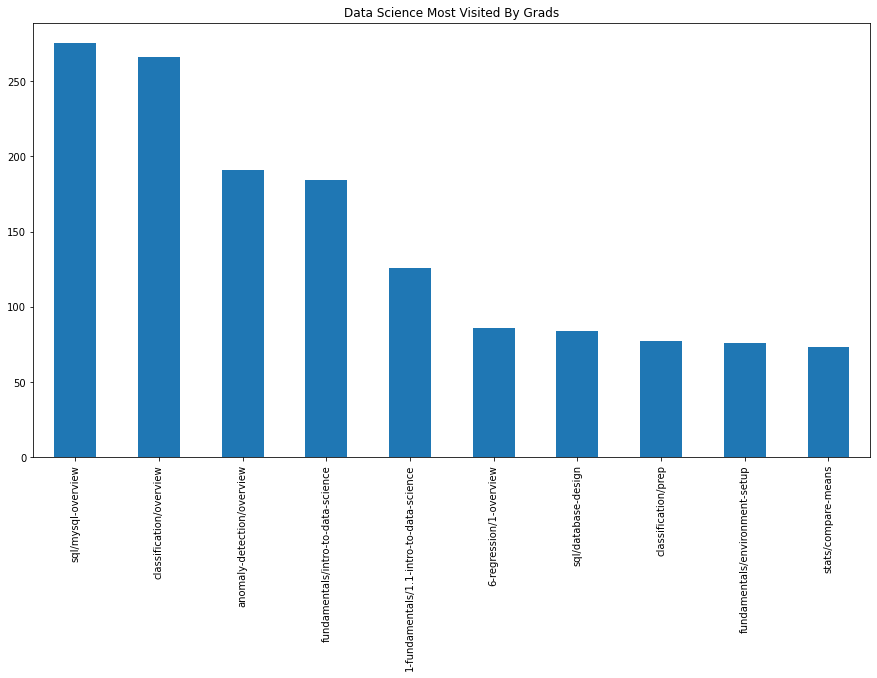

In [283]:
# Plot the top 10 most view topics by grads in Data science 
DS_grads.endpoint.value_counts().head(10).plot.bar(title = 'Data Science Most Visited By Grads', figsize = (15,8));

In [284]:
# Java Full Stack Web Development students referring to the curriculum after graduation
java_full_stack_web_development = grads[(grads.index > grads['end_date']) & (grads['program_id']== 2.0)]

#Group Java Full Stack Web Development students by topic
java_full_stack_web_development.groupby(java_full_stack_web_development.endpoint).head()

date      time                                 endpoint  \
date                                                                       
2018-01-26 2018-01-26  10:59:02                               index.html   
2018-01-26 2018-01-26  10:59:06                                   java-i   
2018-01-26 2018-01-26  11:36:35                             javascript-i   
2018-01-26 2018-01-26  11:36:38                   javascript-i/functions   
2018-01-26 2018-01-26  13:57:51        spring/extra-features/file-upload   
...               ...       ...                                      ...   
2021-04-12 2021-04-12  11:10:47                        jquery/mapbox-api   
2021-04-12 2021-04-12  11:41:59                        jquery/mapbox-api   
2021-04-15 2021-04-15  18:41:27     slides/exceptions_and_error_handling   
2021-04-20 2021-04-20  14:22:21  appendix/further-reading/jquery/effects   
2021-04-20 2021-04-20  14:22:30  appendix/further-reading/jquery/effects   

            user_id  cohort_id      source_ip cohort_name start_date  \
date                                                                   
2018-01-26       21       16.0  71.137.146.71     Niagara 2016-10-26   
2018-01-26       21       16.0  71.137.146.71     Niagara 2016-10-26   
2018-01-26       26       18.0   97.105.19.61   Pinnacles 2017-03-27   
2018-01-26       26       18.0   97.105.19.61   Pinnacles 2017-03-27   
2018-01-26       40       16.0   97.105.19.61     Niagara 2016-10-26   
...             ...        ...            ...         ...        ...   
2021-04-12      495       51.0  72.191.50.129      Deimos 2019-09-16   
2021-04-12      636       57.0    24.28.66.30    Ganymede 2020-03-23   
2021-04-15      614       56.0    174.67.9.84        Apex 2020-02-24   
2021-04-20      495       51.0  72.191.50.129      Deimos 2019-09-16   
2021-04-20      495       51.0  72.191.50.129      Deimos 2019-09-16   

             end_date          created_at           updated_at  program_id  \
date                                                                         
2018-01-26 2017-03-09 2016-10-26 02:34:05  2016-10-26 14:30:19         2.0   
2018-01-26 2017-03-09 2016-10-26 02:34:05  2016-10-26 14:30:19         2.0   
2018-01-26 2017-07-20 2017-03-28 00:33:12  2017-03-28 00:33:12         2.0   
2018-01-26 2017-07-20 2017-03-28 00:33:12  2017-03-28 00:33:12         2.0   
2018-01-26 2017-03-09 2016-10-26 02:34:05  2016-10-26 14:30:19         2.0   
...               ...                 ...                  ...         ...   
2021-04-12 2020-02-27 2019-09-16 13:07:04  2019-09-16 13:07:04         2.0   
2021-04-12 2020-08-20 2020-03-23 17:52:16  2020-03-23 17:52:16         2.0   
2021-04-15 2020-07-29 2020-02-24 15:39:33  2020-07-29 18:41:13         2.0   
2021-04-20 2020-02-27 2019-09-16 13:07:04  2019-09-16 13:07:04         2.0   
2021-04-20 2020-02-27 2019-09-16 13:07:04  2019-09-16 13:07:04         2.0   

                     date_time                     program_name  \
date                                                              
2018-01-26 2018-01-26 10:59:02  Java Full Stack Web Development   
2018-01-26 2018-01-26 10:59:06  Java Full Stack Web Development   
2018-01-26 2018-01-26 11:36:35  Java Full Stack Web Development   
2018-01-26 2018-01-26 11:36:38  Java Full Stack Web Development   
2018-01-26 2018-01-26 13:57:51  Java Full Stack Web Development   
...                        ...                              ...   
2021-04-12 2021-04-12 11:10:47  Java Full Stack Web Development   
2021-04-12 2021-04-12 11:41:59  Java Full Stack Web Development   
2021-04-15 2021-04-15 18:41:27  Java Full Stack Web Development   
2021-04-20 2021-04-20 14:22:21  Java Full Stack Web Development   
2021-04-20 2021-04-20 14:22:30  Java Full Stack Web Development   

                     course  
date                         
2018-01-26  Web Development  
2018-01-26  Web Development  
2018-01-26  Web Development  
2018-01-26  Web Development  
2018-01-26  Web Developm

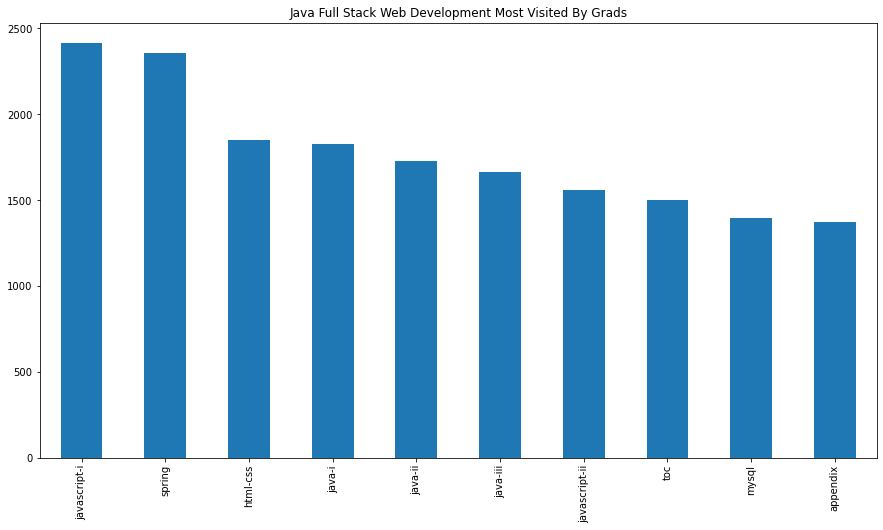

In [286]:
# Plot the top 10 most view topics by grads in Java Full Stack Web Development
java_full_stack_web_development.endpoint.value_counts().head(10).plot.bar(title = 'Java Full Stack Web Development Most Visited By Grads', figsize = (15,8));

In [287]:
# PHP Full Stack Web Development students referring to the curriculum after graduation
PHP_full_stack_web_development = grads[(grads.index > grads['end_date']) & (grads['program_id']== 1.0)]

#Group PHP Full Stack Web Development students by topic
PHP_full_stack_web_development.groupby(PHP_full_stack_web_development.endpoint).head()

date      time  \
date                              
2018-01-26 2018-01-26  09:56:02   
2018-01-26 2018-01-26  09:56:05   
2018-01-26 2018-01-26  09:56:06   
2018-01-26 2018-01-26  10:14:51   
2018-01-26 2018-01-26  10:15:02   
...               ...       ...   
2021-02-18 2021-02-18  05:59:41   
2021-02-18 2021-02-18  05:59:45   
2021-02-26 2021-02-26  09:38:22   
2021-03-03 2021-03-03  23:53:35   
2021-03-05 2021-03-05  11:16:56   

                                                     endpoint  user_id  \
date                                                                     
2018-01-26                                            java-ii        1   
2018-01-26                java-ii/object-oriented-programming        1   
2018-01-26                 slides/object_oriented_programming        1   
2018-01-26                                       javascript-i       11   
2018-01-26                             javascript-i/functions       11   
...                                                       ...      ...   
2021-02-18  content/jquery/essential-methods/gitbook/image...       51   
2021-02-18  content/jquery/essential-methods/attributes-an...       51   
2021-02-26                                                git      139   
2021-03-03  content/javascript/bom-and-dom/google_maps_api...       80   
2021-03-05                              ajax-api-request.html       80   

            cohort_id      source_ip cohort_name start_date   end_date  \
date                                                                     
2018-01-26        8.0   97.105.19.61     Hampton 2015-09-22 2016-02-06   
2018-01-26        8.0   97.105.19.61     Hampton 2015-09-22 2016-02-06   
2018-01-26        8.0   97.105.19.61     Hampton 2015-09-22 2016-02-06   
2018-01-26        1.0   97.105.19.61      Arches 2014-02-04 2014-04-22   
2018-01-26        1.0   97.105.19.61      Arches 2014-02-04 2014-04-22   
...               ...            ...         ...        ...        ...   
2021-02-18       13.0  70.122.42.101       Kings 2016-05-23 2016-09-15   
2021-02-18       13.0  70.122.42.101       Kings 2016-05-23 2016-09-15   
2021-02-26       14.0  174.25.169.61      Lassen 2016-07-18 2016-11-10   
2021-03-03       14.0  136.50.29.193      Lassen 2016-07-18 2016-11-10   
2021-03-05       14.0  136.50.29.193      Lassen 2016-07-18 2016-11-10   

                    created_at           updated_at  program_id  \
date                                                              
2018-01-26 2016-06-14 19:52:26  2016-06-14 19:52:26         1.0   
2018-01-26 2016-06-14 19:52:26  2016-06-14 19:52:26         1.0   
2018-01-26 2016-06-14 19:52:26  2016-06-14 19:52:26         1.0   
2018-01-26 2016-06-14 19:52:26  2016-06-14 19:52:26         1.0   
2018-01-26 2016-06-14 19:52:26  2016-06-14 19:52:26         1.0   
...                        ...                  ...         ...   
2021-02-18 2016-06-14 19:52:26  2016-06-14 19:52:26         1.0   
2021-02-18 2016-06-14 19:52:26  2016-06-14 19:52:26         1.0   
2021-02-26 2016-07-18 19:06:27  2016-07-18 19:06:27         1.0   
2021-03-03 2016-07-18 19:06:27  2016-07-18 19:06:27         1.0   
2021-03-05 2016-07-18 19:06:27  2016-07-18 19:06:27         1.0   

                     date_time                    program_name  \
date                                                             
2018-01-26 2018-01-26 09:56:02  PHP Full Stack Web Development   
2018-01-26 2018-01-26 09:56:05  PHP Full Stack Web Development   
2018-01-26 2018-01-26 09:56:06  PHP Full Stack Web Development   
2018-01-26 2018-01-26 10:14:51  PHP Full Stack Web Development   
2018-01-26 2018-01-26 10:15:02  PHP Full Stack Web Development   
...                        ...                             ...   
2021-02-18 2021-02-18 05:59:41  PHP Full Stack Web Development   
2021-02-18 2021-02-18 05:59:45  PHP Full Stack Web Development   
2021-02-26 2021-02-26 09:38:22  PHP Full Stack Web Development   
2021-03-03 2021-03-03 23:53:35  PHP F

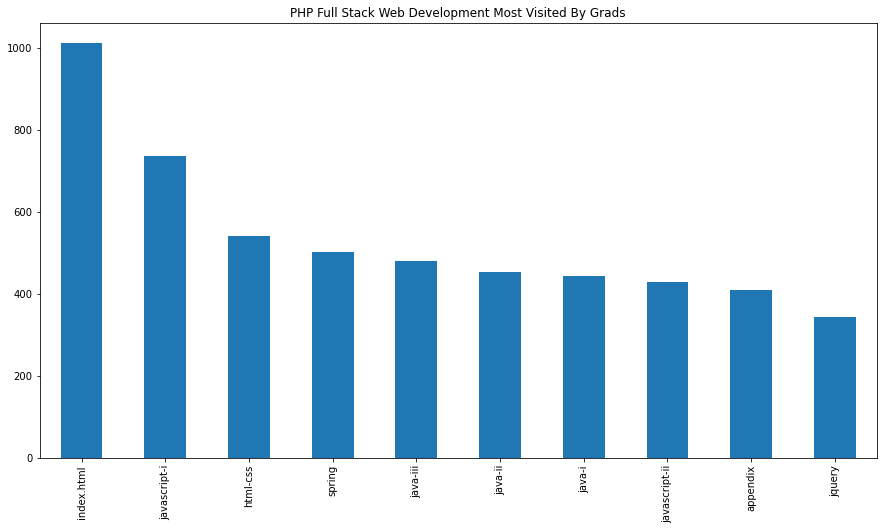

In [288]:
# Plot the top 10 most view topics by grads in PHP Full Stack Web Development
PHP_full_stack_web_development.endpoint.value_counts().head(10).plot.bar(title = 'PHP Full Stack Web Development Most Visited By Grads', figsize = (15,8));

In [289]:
# Front End Web Development students referring to the curriculum after graduation
front_end_web_development = grads[(grads.index > grads['end_date']) & (grads['program_id']== 4.0)]

# Group Front End Web Development students by topic
front_end_web_development.groupby(front_end_web_development.endpoint).head()

date      time                                     endpoint  \
date                                                                           
2018-03-22 2018-03-22  19:01:54                             content/html-css   
2018-03-22 2018-03-22  19:01:54  content/html-css/gitbook/images/favicon.ico   
2018-03-22 2018-03-22  19:02:47                             content/html-css   
2018-03-22 2018-03-22  19:02:52           content/html-css/introduction.html   

            user_id  cohort_id      source_ip cohort_name start_date  \
date                                                                   
2018-03-22      152        9.0  207.68.209.17      Apollo 2015-03-30   
2018-03-22      152        9.0  207.68.209.17      Apollo 2015-03-30   
2018-03-22      152        9.0  207.68.209.17      Apollo 2015-03-30   
2018-03-22      152        9.0  207.68.209.17      Apollo 2015-03-30   

             end_date          created_at           updated_at  program_id  \
date                                                                         
2018-03-22 2015-07-29 2016-06-14 19:52:26  2016-06-14 19:52:26         4.0   
2018-03-22 2015-07-29 2016-06-14 19:52:26  2016-06-14 19:52:26         4.0   
2018-03-22 2015-07-29 2016-06-14 19:52:26  2016-06-14 19:52:26         4.0   
2018-03-22 2015-07-29 2016-06-14 19:52:26  2016-06-14 19:52:26         4.0   

                     date_time               program_name           course  
date                                                                        
2018-03-22 2018-03-22 19:01:54  Front End Web Development  Web Development  
2018-03-22 2018-03-22 19:01:54  Front End Web Development  Web Development  
2018-03-22 2018-03-22 19:02:47  Front End Web Development  Web Development  
2018-03-22 2018-03-22 19:02:52  Front End Web Development  Web Development

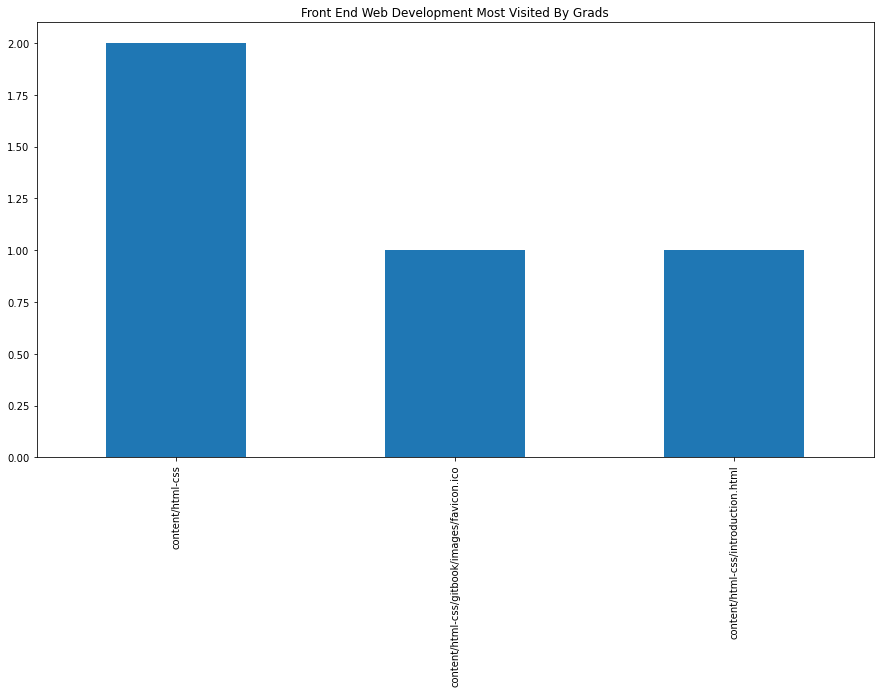

In [291]:
# Plot the view topics by grads in PHP Front End Web Development
front_end_web_development.endpoint.value_counts().head(10).plot.bar(title = 'Front End Web Development Most Visited By Grads', figsize = (15,8));

7. Which lessons are leasts accessed?

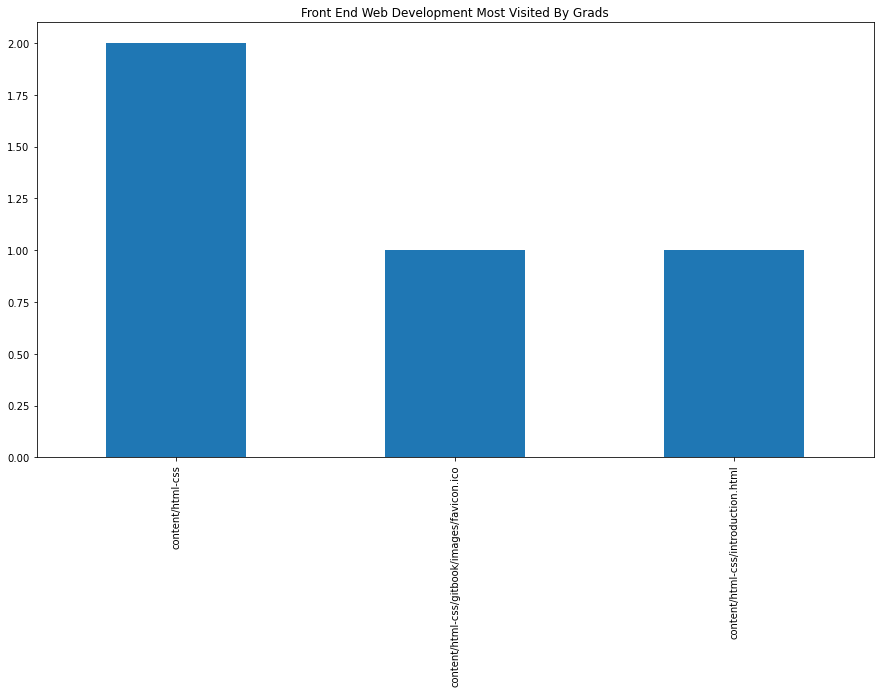

In [292]:
# Plot the view topics by grads in PHP Front End Web Development
front_end_web_development.endpoint.value_counts().head(10).plot.bar(title = 'Front End Web Development Most Visited By Grads', figsize = (15,8));

In [302]:
# Create series for data science only where we count the accessed endpoints
least_accessed_ds = df_dw[df_dw['program_name'] == 'Data Science'].endpoint.value_counts()

In [303]:
# turn least_accessed seriesn into panda df
least_accessed_ds = pd.DataFrame(least_accessed_ds)
# arrange least_accessed data frame by the count of enpoit 
least_accessed_ds = least_accessed_ds.sort_values('endpoint').index.value_counts().rename('endpoint_count').reset_index()

In [304]:
least_accessed_ds

index  endpoint_count
0                  database-design               1
1                      nlp/project               1
2        clustering/using-clusters               1
3       appendix/cli/7-more-topics               1
4               timeseries/project               1
..                             ...             ...
626             11-nlp/pos-tagging               1
627                   cli/overview               1
628  darden-python-assessment.html               1
629                       appendix               1
630        classification/overview               1

[631 rows x 2 columns]

In [305]:
# export least acessed to csv
least_accessed_ds.to_csv('least_accessed_ds.csv')

### Takeaway

- 631 endpoints could be classified as the least accessed.

-------------------

In [306]:
# Create series for web development records only where we count the accessed endpoints
least_accessed_by_web_developers = df_dw[df_dw['program_name'] != 'Data Science'].endpoint.value_counts();

In [308]:
# turn least_accessed_by_web_developers seriesn into panda df
least_accessed_by_web_developers = pd.DataFrame(least_accessed_by_web_developers)

In [309]:
# arrange least_accessed data frame by the count of enpoit 
least_accessed_by_web_developers = least_accessed_by_web_developers.sort_values('endpoint').index.value_counts().rename('endpoint_count').reset_index()

In [310]:
least_accessed_by_web_developers

index  endpoint_count
0                                appendix/spring/seeder               1
1                       content/git/gitignore-file.html               1
2                     content/javascript/functions.html               1
3     content/php_ii/array-functions/sorting-arrays....               1
4     content/php_i/intro-to-operators/gitbook/image...               1
...                                                 ...             ...
1253                       content/primitive-types.html               1
1254                                              php_i               1
1255                                       appendix/cli               1
1256                                       registration               1
1257                                                toc               1

[1258 rows x 2 columns]

In [311]:
# export least acessed to csv
least_accessed_by_web_developers.to_csv('least_accessed_by_web_developers.csv')

8. Anything else I should be aware of?

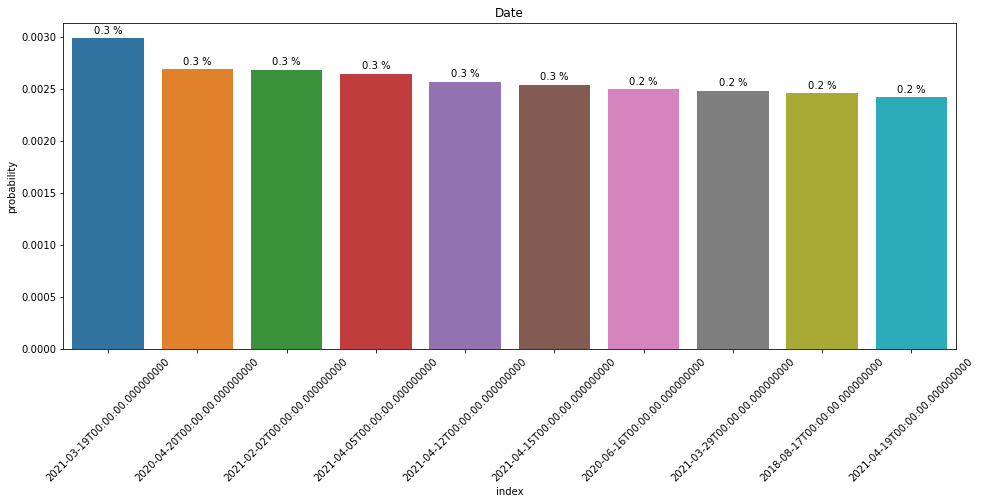

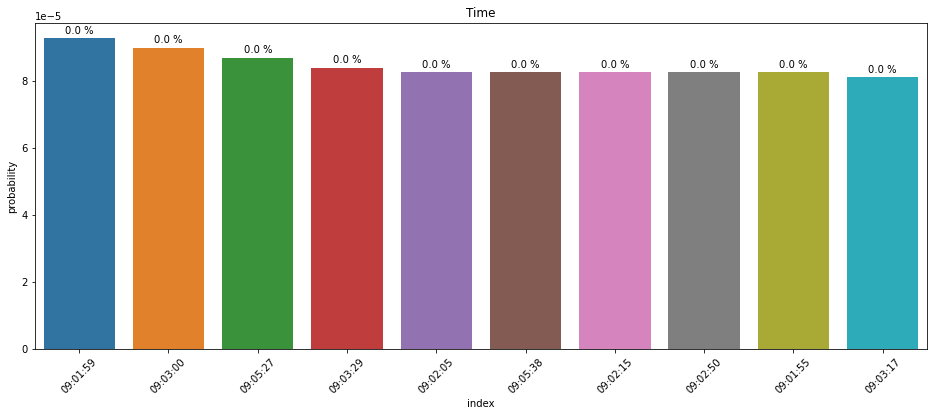

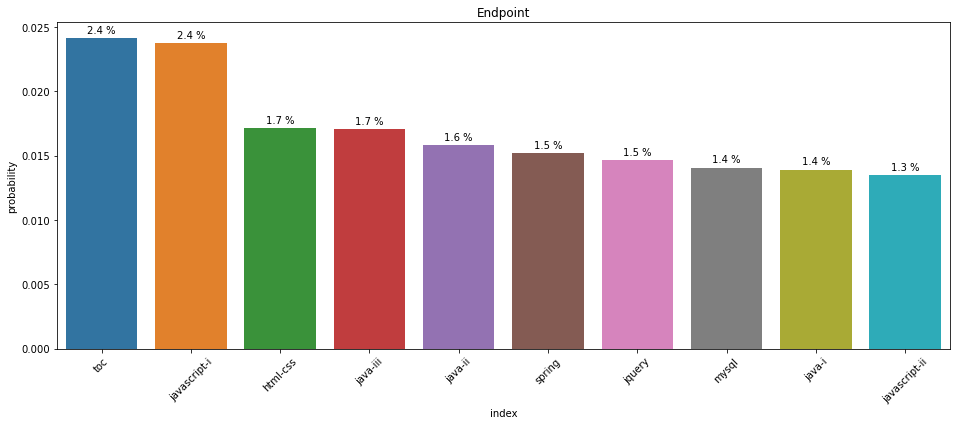

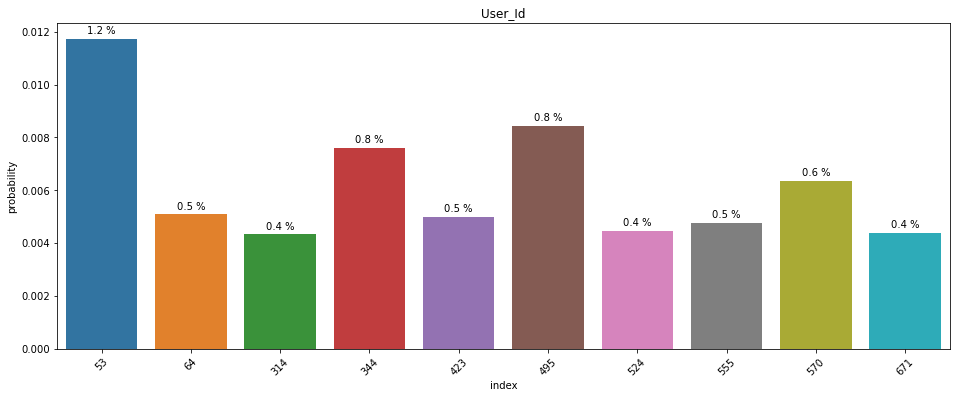

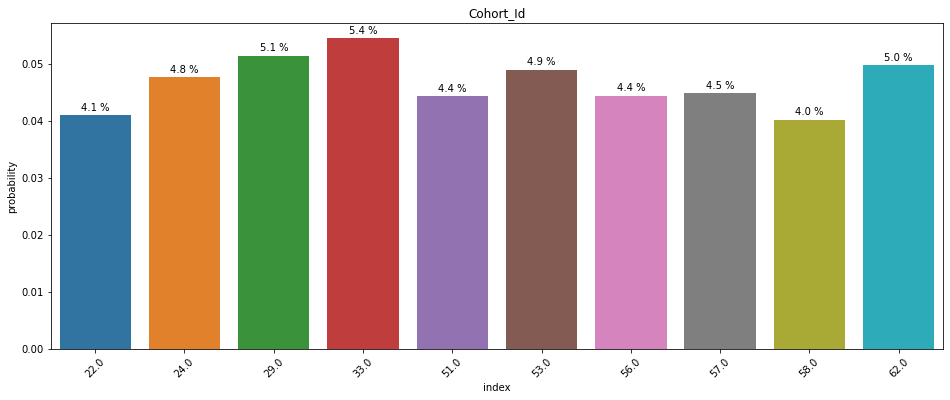

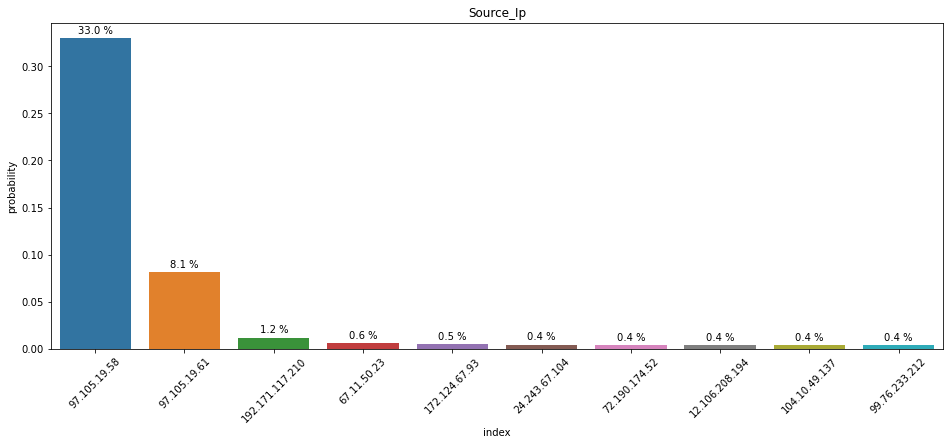

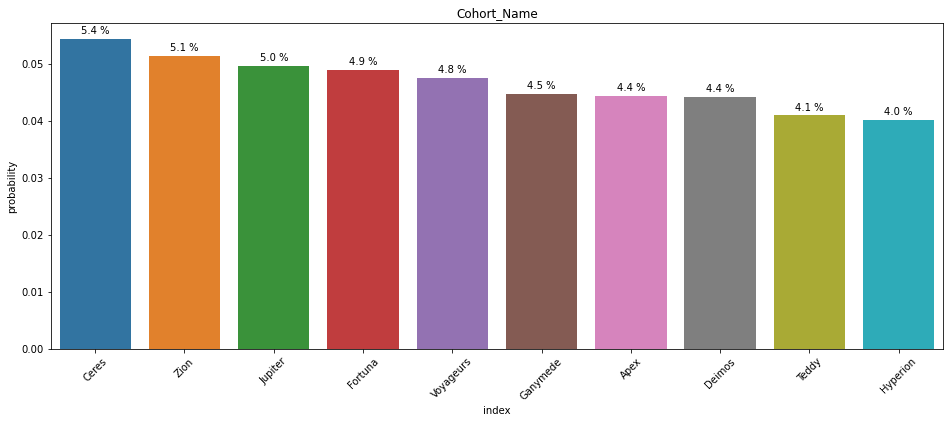

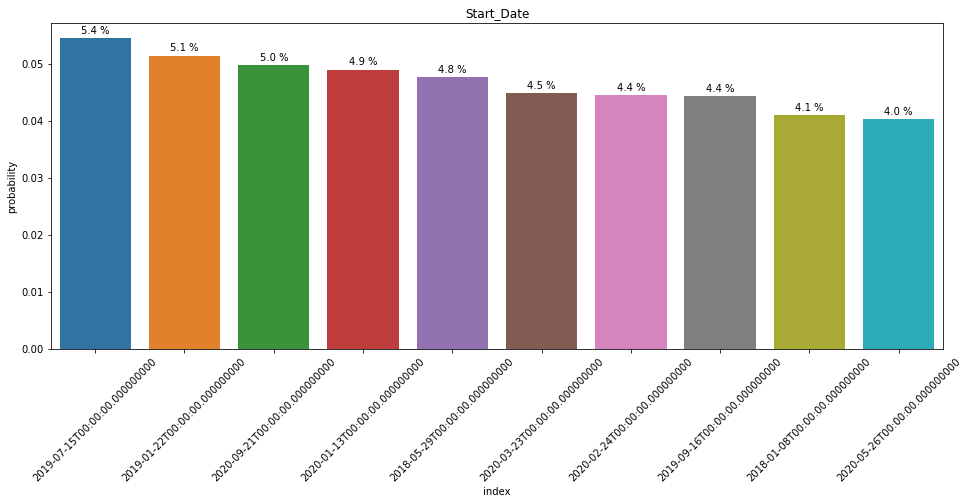

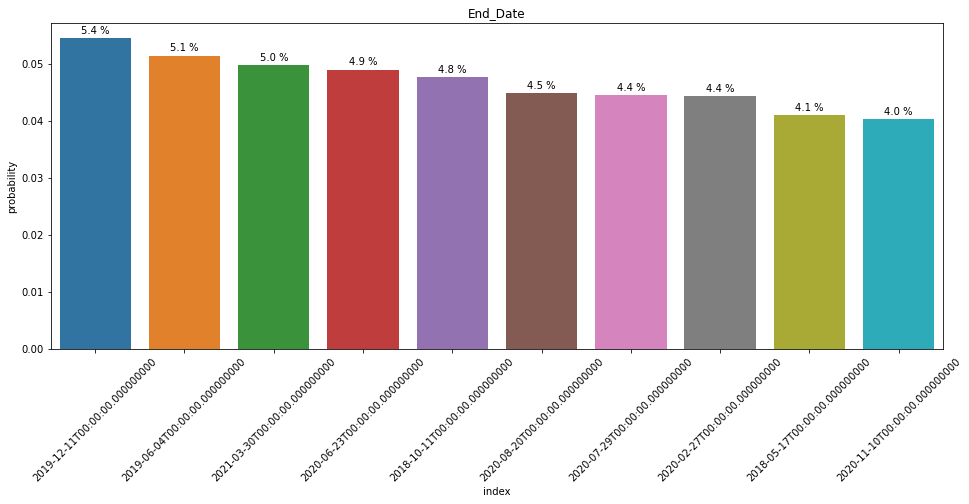

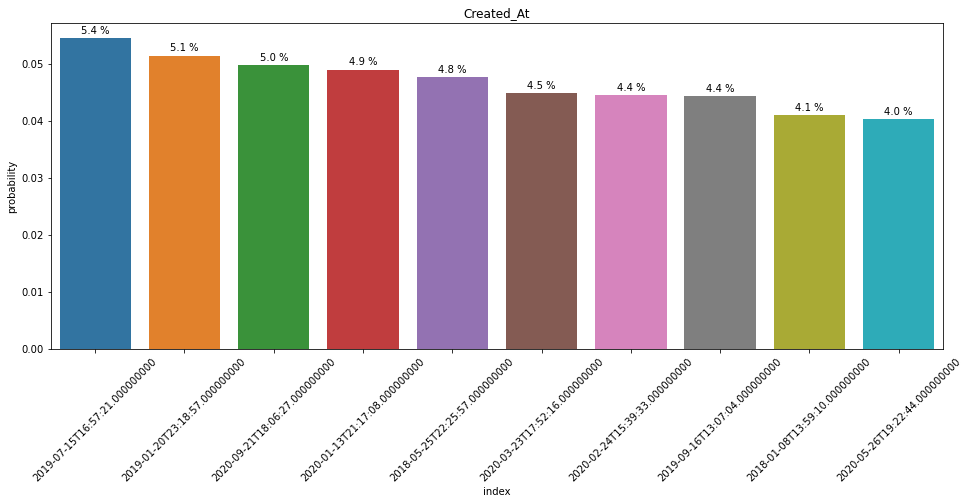

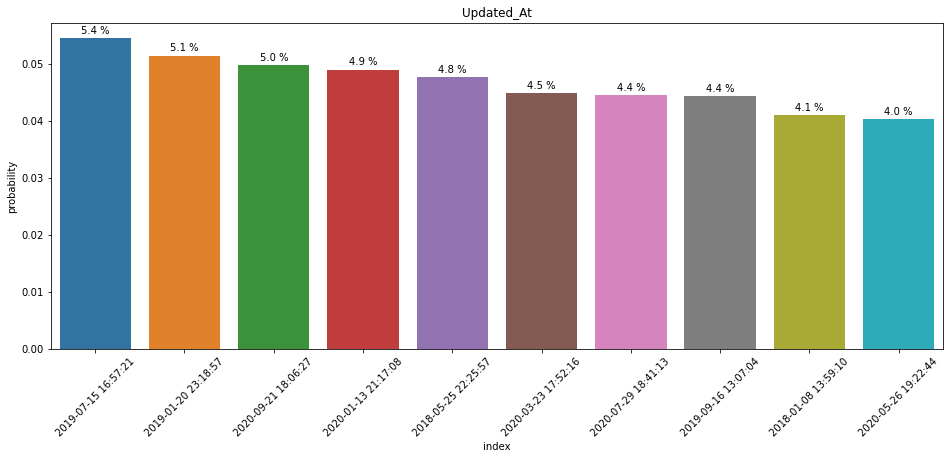

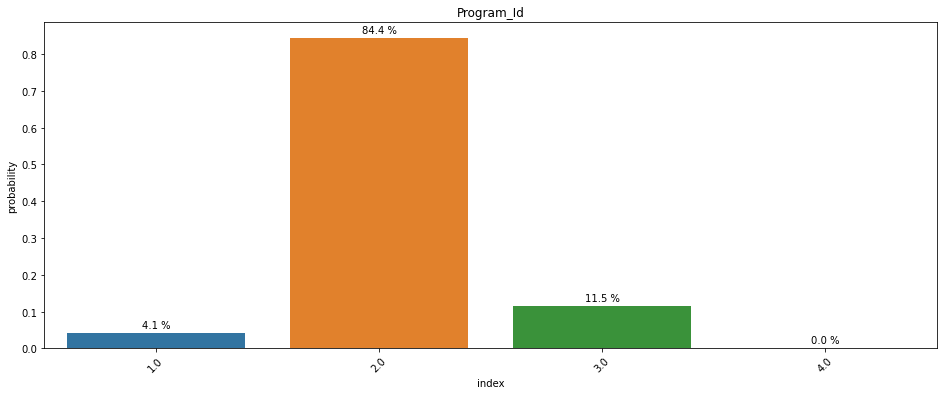

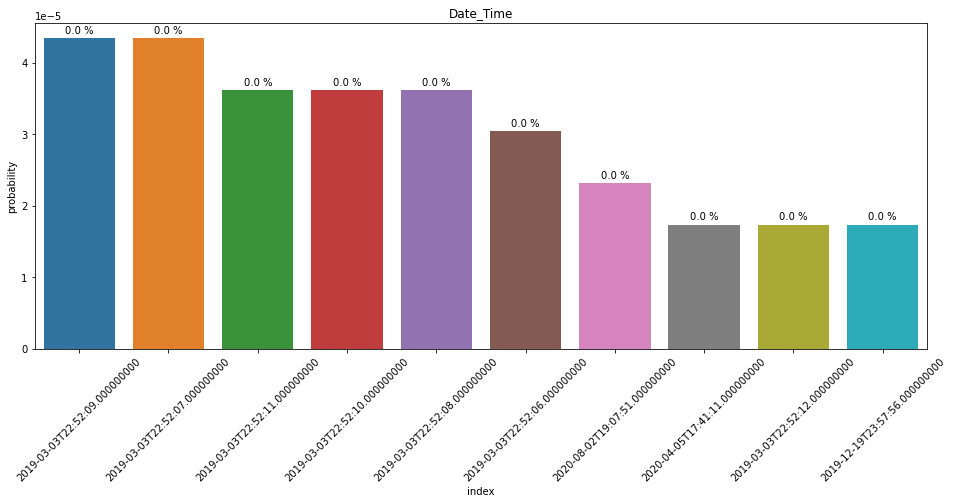

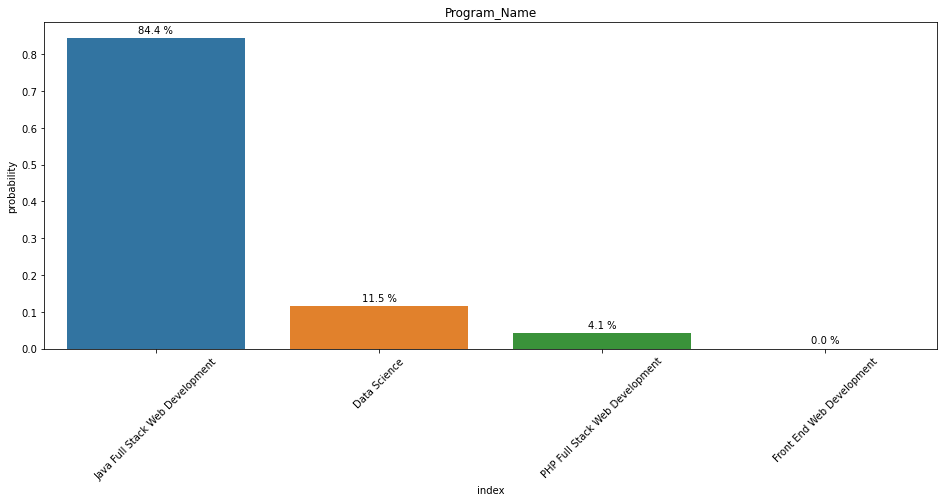

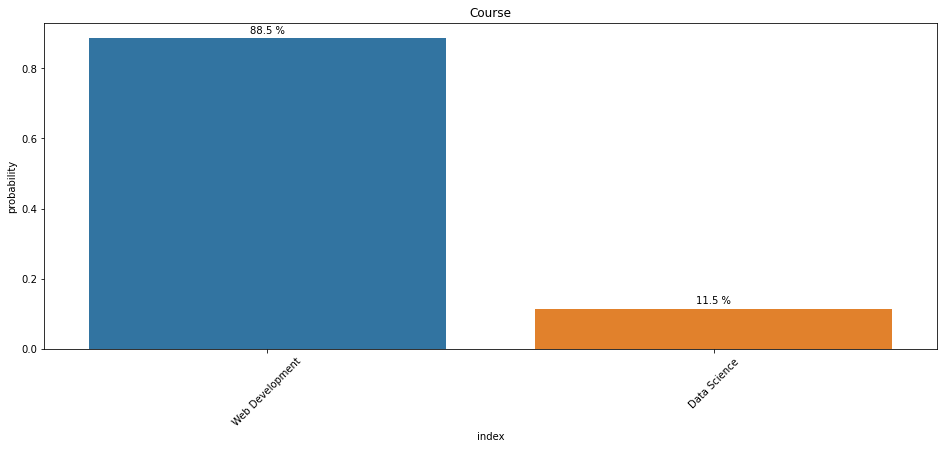

In [40]:
# create graphs based on the percentage taken by the top 10 by column  
for col in df_dw.columns:
    plt.figure(figsize = (16, 6))
    splot = sns.barplot(x = 'index', y = col, data = df_dw[col].value_counts(normalize=True).reset_index().sort_values(
        by = col, ascending = False).head(10))
    for p in splot.patches:
        splot.annotate(format(p.get_height() * 100, '.1f') + ' %', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size = 10,  
                   xytext = (0, 8), 
                   textcoords = 'offset points')
    plt.xticks(rotation = 45)  
    plt.title(col.title())
    plt.ylabel('probability')
    plt.show()

In [312]:
# most accessed endpoints by cohort 
with pd.option_context('display.max_rows', None):
    counts = pd.DataFrame(df_dw.groupby('endpoint').cohort_name.value_counts())
    display(counts[counts > 1000].dropna())

cohort_name
endpoint                cohort_name             
classification/overview Darden            1109.0
javascript-i            Ceres             1003.0
toc                     Jupiter           1866.0
                        Zion              1465.0
                        Fortuna           1293.0
                        Hyperion          1022.0